## _Preamble_


    The motivation behind this project is a need for efficient tools capable of handling the large amount of spectroscopy made available by the Sloan Digital Sky Survey (SDSS) and similar institutions. As we rapidly gain access to more stellar data, going through each and every piece of information with human resources is neither preferable nor doable. There is a need for reliable models capable of categorizing and label stars in an efficient manner, so that the information might be utilized to aid in bigger questions. For instance, the use of type 1 supernova in constructing a cosmic distance ladder and estimations of the cosmic expansion rate.

    The goal of the following project is to construct a framework to test models that predicts white dwarf (WD) labels from WD spectra. More precisely to take the WD located by Kleinman et al. [\[2012\]](https://arxiv.org/abs/1212.1222) and build a framework around them using the Cannon. The secondary goal is to use this framework to explore variations of potential stellar models. Through this exploration we hope to find a model that yields accurate estimates of WD stellar labels given any WD spectra. 

    The project was successful in establishing a framework to explore models in, and in testing a model assuming a second order label dependence. However, the scope of the project had to be reduced in order to fit the available time frame. There was not enough time to properly test any other model beyond the initial second order dependence model. Therefore the secondary goal was barely touched upon.

    The descope was found necessary due to unexpected time-consuming properties of the data. Initially, a lot more time than expected was used on understanding the data structure and how to obtain the data from the SDSS fits-files. Once the data was obtained an unexpected amount of time was also used on understanding the nature of the data and the white dwarf spectra. There was confusion regarding the quality of the spectra, and the noise associated with each spectrum. It was also hard to figure out the structure of how the spectra varied across the large temperature ranges and the variations in the trends of surface gravitation. Therefor this project was descoped into applying only a second order label dependence model to the spectra, and evaluate the result. The project was on the other hand successful in establishing a framework for testing new models, so that the application of alternative models might be left for future work.

<pre>
</pre>

<pre>
</pre>


# <center>  Modeling white dwarf spectra using the Cannon</center>

## <center> Abstract </center>
    
A framework is developed for testing models that determines the effective temperature and surface gravitation of white dwarfs from their spectra. A total of 14,120 established hydrogen rich (DA) white dwarfs and their labels are selected from the Kleinman catalog. The objects are cross-matched with the SDSS data archive server (DAS) to obtain the corresponding WD spectra. The data is cleansed primarily based on signal-to-noise-ratios and bitmasks, and the spectra are pseudo-continuum normalized by dividing each spectra on a fifth order polynomial fit to the curves. Then a framework is built as a probabilistic generative model inferred from a training set by minimizing the log likelihood. The model is initially formulated as a second order label dependence on the spectra, and evaluated in regards to its consistency with the Kleinman labels. When the model is applied to the data it initially fails, and shows a tendency to fit bifurcate at low temperatures. The model is found to fit well when applied only to the high temperature regime, with RMS$_{T eff}$ = 1520.4 K and RMS$_{Log g}$ = 0.221 dex. When the model is applied solely to the intermediate temperature regions it still fits bifurcatly against the lower side of T. When applied soley to the low temperature region the model fits consistently for temperature with a RMS$_{T eff}$ = 194.7 K, but sees an increase in the uncertainty for log g with RMS$_{Log g}$ = 0.377 dex. Possible reasons for this inconsistency is discussed. In the end of this paper, a neural net is applied to the psudo-normalized data in order to preforme a quick probe for additional information. The study is overall successful in establishing an overall framework. It is left for future work to use the framework in exploration of alternative models that might propose a better fit for WD spectra, and WDs with other dominant metallicity compositions.

<pre>
</pre>


<pre>
</pre>


## 0. Introduction

New spectroscopic surveys are rapidly providing stellar spectra from millions of stars across the sky. Of particular importance are the white dwarf sub-group, that provides links between the history and future evolution of the Milky Way. These low-mass, electron-degenerate objects are the final stage of an overwhelming majority of all stars formed in previous stellar generations, and stars born in the future. Including our very own sun. At the same time this major availability of data imposes a great challenge in regards to efficiently abstracting useful information. This paper investigates a method for deriving the effective temperature and surface gravitation simultaneous for multiple white dwarf spectra. It is our hope that a model capable of taking the spectra and directly predict the stellar labels will ease this formidable challenge. 

This paper is based on the work of Kleinman et al. [\[2012\]](https://arxiv.org/abs/1212.1222) of locating white dwarf spectra in the SDSS DAS, and the construction of the Cannon by Ness et al [\[2015\]](https://arxiv.org/abs/1501.07604). Section 1 contains instructions for obtaining the data and cleansing it. A cross-match is preformed between the effective temperature and surface gravitation of 14,120 hydrogen rich (DA) WD from the Kleinman catalog with their corresponding spectra from the SDSS DAS. Thus yielding a complete set of training data that contains WD labels and spectra. The data is then cleansed in section 0.2 based primarily on signal-to-noise-ratios, as well as the bitmasks accompanying the spectra in section 0.3. A total of 3252 spectra are found sutable for this project. All spectra are pseudo-continuum-normalized in a consistent manner in section 0.4, based upon a fifth order polynomial fit to the psudo-continuum. Section 2 deals with the construction of the model. The model is initially taken to assume a second order label dependence in the spectra, and is trained on a set of 1626 WDs. The model is then applied to a validation set of 1626 spectra in section 3, and compared to the original Kleinman labels. The model is then fitted separately to spectra with different ranges of temperature, in order to evaluate the performance and impact of internal label variations in the model.

White dwarfs are rich laboratories that provides us with information otherwise not available. For instance, the current temperature-luminosity distribution of Milky Way White Dwarfs constrains models of cosmological evolutionary history. Like the type 1 supernova that yields distance indicators demonstrating the acceleration of the universe. [Provencal, 2012](https://cor.gsfc.nasa.gov/RFI2012/docs/). It is therefore believed that by properly understanding these objects, we have the opportunity to get closer to an understanding of how are universe came to evolve, and where it are heading for. 
<pre>
</pre>


_Setting initial adjustments for the notebook:_

In [100]:
""" Initial modules and settings
"""

import matplotlib.pyplot as plt, matplotlib, seaborn as sns 
from tqdm import trange 
import numpy as np
import pandas as pd 
import os
import corner
from astropy.io.fits import getdata
from astropy.table import Table
%matplotlib inline
from scipy.optimize import curve_fit
from astropy.io import fits
from scipy.stats import gaussian_kde
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize

sns.set()
sns.set_context("poster")


# Suppress warnings
# Comment this out if you wish to see the warning messages
import warnings
warnings.filterwarnings('ignore')

# General Plot Layout Parameters

def reset_rcParams():
    """ Resets all plotting parameters to easy, preferable status
    """
    matplotlib.rcParams['figure.figsize']  = (20.0, 10.0)
    matplotlib.rcParams['axes.grid']       = True
    matplotlib.rcParams['font.size']       = 30
    matplotlib.rcParams['font.family']     = 'OfficinaSanITCBoo'
    matplotlib.rcParams['axes.labelsize']  = 0.9*plt.rcParams['font.size']
    matplotlib.rcParams['axes.titlesize']  = 0.9*plt.rcParams['font.size']
    matplotlib.rcParams['legend.fontsize'] = 0.9*plt.rcParams['font.size']
    matplotlib.rcParams['xtick.labelsize'] = 0.9*plt.rcParams['font.size']
    matplotlib.rcParams['ytick.labelsize'] = 0.9*plt.rcParams['font.size']
    matplotlib.rcParams['scatter.marker']  = 'o'
    matplotlib.rcParams['axes.titlepad']   = 30
    matplotlib.rcParams['axes.labelpad']   = 20
    matplotlib.rcParams['xtick.major.pad'] ='2'
    matplotlib.rcParams['ytick.major.pad'] ='5'

def adjust_rcParams(fontsize,labelsize, labelpad, tickpad):
    """ To efficiently adjust plot parameters when they misbehave
    """
    matplotlib.rcParams['font.size']       = fontsize
    matplotlib.rcParams['xtick.labelsize'] = labelsize*plt.rcParams['font.size']
    matplotlib.rcParams['ytick.labelsize'] = labelsize*plt.rcParams['font.size']
    matplotlib.rcParams['axes.labelsize']  = labelsize*plt.rcParams['font.size']
    matplotlib.rcParams['axes.labelpad']   = labelpad
    matplotlib.rcParams['xtick.major.pad'] = str(tickpad)
    matplotlib.rcParams['ytick.major.pad'] = str(tickpad)
    
reset_rcParams()    

<pre>
</pre>

______________________________________________________

## 0. Accessing appropriate WD Data
______________________________________________________

<pre>
</pre>

### 0.1 Obtaining Kleinman and SDSS WD

In this work we will assume that the spectra categorized as white dwarfs by Kleinman et al [ \[2012\] ](https://arxiv.org/abs/1212.1222) with certainty are withe dwarfs, and the labels of Kleinman is taken to be true effective temperatures and surface gravitation of the stars. Questions regarding whether or not this is an accurate assumption is considered to be beyond the scope of this paper. 

<pre> 
</pre>

### 0.1.a The Kleinman Catalog

The white dwarf data used in this project is based on spectra from the SDSS DR7 and the Kleinman et al white dwarf catalog. The Kleinman catalog provides a selection of spectra believed to be white dwarfs, as well as estimates for both the effective temperature ($T_{eff}$) and surface gravitation (Log g) for all objects. All objects are identified by a unique combination of a modified Julian date (MJD) the spectra was obtained on, a SDSS plate number and a SDSS Fiber ID. The catalog is accessible through [VizieR](http://vizier.u-strasbg.fr/viz-bin/VizieR?-source=J/ApJS/204/5), and contains 20.240 subjects considered to be different variations of white dwarfs. An initial selection is made of all white dwarfs corresponding to the subcategory DA. That is 14.120 white dwarfs with hydrogen dominated atmospheres. 

In [101]:
filename = 'AllDA.fit'

KleinmanDA_catalogue =  Table.read(filename, format='fits').to_pandas()
KleinmanDA_catalogue.describe()

,Plate,MJD,Fiber,RAJ2000,DEJ2000,SNg,pm,pmPA,Teff,e_Teff,log_g_,e_log_g_,Mass,e_Mass
count,14120.000000,14120.000000,14120.000000,14120.000000,14120.000000,14120.000000,14120.00000,14120.000000,14120.000000,14120.000000,14120.000000,14120.000000,14120.000000,14120.000000
mean,1541.335552,53127.291714,322.584348,172.435810,24.870853,12.758610,28.88289,170.842712,17028.253895,485.944476,7.950753,0.133567,0.558650,0.059692
std,827.198542,890.136020,188.734735,77.818579,20.561128,9.633905,37.87427,95.602594,10345.646673,766.561504,0.407031,0.100842,0.230254,0.048179
min,266.000000,51602.000000,1.000000,0.028139,-17.889800,0.510000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,761.000000,52320.000000,157.000000,129.308182,6.435825,5.970000,7.80000,113.000000,10298.000000,124.000000,7.790000,0.066000,0.493000,0.026000
50%,1568.000000,53089.000000,325.000000,168.132910,23.732216,9.880000,18.20000,178.900000,14640.500000,316.000000,7.950000,0.111000,0.577000,0.051000
75%,2276.000000,53797.000000,491.000000,223.907905,39.908491,16.132500,36.30000,239.700000,20018.000000,597.000000,8.140000,0.176000,0.672000,0.083000
max,2974.000000,54653.000000,640.000000,359.980920,84.515564,89.740000,618.80000,359.900000,99018.000000,19879.000000,10.000000,2.164000,1.377000,0.494000


<pre>
</pre>

### 0.1.b The DAS database

By generating a list of the MJD, Fiber ID and plate number one can request a list of Wget links matching the Kleinman objects through the [DAS database](http://das.sdss.org/www/html/post_fibers.html). 
The wget links yields one single fits file for every spectra requested. 
.

In [102]:
def make_DASFile(df, outfile):
    """ Returns Plate-, MJD- and Fiber list readable by DAS
    """
    with open(outfile,"w") as File_object:
        for i in range(len(df['Plate'].values)):
            File_object.write(str(int(df['Plate'][i])) +', ' + str(int(df['MJD'][i])) +', ' + str(int(df['Fiber'][i])) + '\n')

# Request DAS list in file "DA_files.txt"            
make_DASFile(KleinmanDA_catalogue, 'DA_files.txt')


# Uppload list to DAS to obtain a list file containing all wget links
#! wget -P spectra/ -i sdss-wget-5dWUhF_5002.lis

<pre>
</pre>

### 0.1.c Reading WD spectra

The fits-files are read according to the data model described at [SDSS DR7](http://classic.sdss.org/dr7/dm/flatFiles/spSpec.html). To merge the two databases a common key is formulated based on the MJD-plate-fiber identification number. The wavelengths are given through the parameters COEFF 0 (Center wavelength (log10) of first pi), and COEFF 1 (Log10 dispersion per pixel), and the vacuum wavelengths are given by the relation
<pre>
</pre>
<center>
$\lambda = 10^{COEFF0 + COEFF1*i}$
</center>

where i is the i$^{th}$ pixel. After completing this section and taking a closer look at the spectra, it was decided to only use the spectra pixel values corresponding to the indexes i = [0, 2500]. This is due to that the end pixels of every spectra carries high noise values, and in the end actually increases the RMS of the model fit when taken into consideration. We see no immediate benefit with or reason why these pixels should be taken into consideration at this point.

In [103]:
path = 'spectra/'

def spectra_database(path, N):
    """ Reads all spectra from fits-files in path
    Formulates wavelength spectra
    Retruns: All spectra, noise, mask, key and wavelengths
    """
    spectra, noise, mask = [], [], []
    filename_key = []                               # Name: spSpec-mmmmm-pppp-fff.fit, where mmmmm is the mjd, pppp is the plate id number and fff is the fiber id number
    C0, C1 = [], []
    wavelengths = []
    for filename in os.listdir(path):
        with fits.open(path + filename, memmap=False) as hdul:
            filename_key.append(filename[7:21])
            spectra.append(hdul[0].data[0][0:N])
            noise.append(hdul[0].data[2][0:N])
            mask.append(hdul[0].data[3][0:N])
            C0.append(hdul[0].header['COEFF0'])
            C1.append(hdul[0].header['COEFF1'])

    
    for i in range(len(C0)):
        wavelengths.append([10**(C0[i]+C1[i]*j)for j in range(N)])
        

    d = {'key': filename_key, 'spectra': spectra, 'noise': noise, 'Bit_Mask': mask, 'wavelengths': wavelengths}
    df = pd.DataFrame(d)
    
    return df

DAS_spectra = spectra_database(path, 2500)
DAS_spectra.tail()

,key,spectra,noise,Bit_Mask,wavelengths
14115,53135-1389-178,"[58.891, 58.871, 58.851, 58.831, 58.8111, 58.7...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 6.2683177, 6.02...","[16777216.0, 16777216.0, 16777216.0, 16777216....","[3789.6578379947123, 3790.5305394288553, 3791...."
14116,52380-0921-491,"[5.99086, 1.1054, 2.40245, 9.15639, 9.14234, 4...","[6.43033, 3.9125834, 3.862821, 3.891849, 3.839...","[67108864.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0...","[3798.3939015450715, 3799.2686147637914, 3800...."
14117,52708-1187-472,"[4.57503, 4.57553, 4.57602, 4.57652, 4.57701, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[16777216.0, 16777216.0, 16777216.0, 16777216....","[3795.7709700253163, 3796.6450792221963, 3797...."
14118,53442-1768-534,"[21.5316, 21.5291, 21.5267, 21.5242, 21.5217, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[16777216.0, 16777216.0, 16777216.0, 16777216....","[3790.5305394288553, 3791.4034418330666, 3792...."
14119,51810-0415-211,"[33.5186, 33.5203, 33.5221, 33.5238, 33.5255, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[16777216.0, 16777216.0, 16777216.0, 16777216....","[3789.6578379947123, 3790.5305394288553, 3791...."


In [104]:
def merge_data_on_key(df1, df2):
    """ Fromulates and merges on common Key
    Returns: Combined database
    """
    fiberid = np.array(df2['Fiber'].values.astype(str))
    for i in range(len(fiberid)):
        if len(str(fiberid[i]))== 2:
            fiberid[i] = '0' + str(fiberid[i])
        elif len(str(fiberid[i]))== 1:
            fiberid[i] = '00' + str(fiberid[i])

    plateid = np.array(df2['Plate'].values.astype(str))
    for i in range(len(plateid)):
        if len(str(plateid[i]))== 3:
            plateid[i] = '0' + str(plateid[i])
        elif len(str(plateid[i]))== 2:
            plateid[i] = '00' + str(plateid[i])
        elif len(str(plateid[i]))== 1:
            plateid[i] = '000' + str(plateid[i])

    df2['Fiber_id'] = fiberid
    df2['Plate_id'] = plateid

    df2['key'] = df2['MJD'].astype(str) + '-' + df2['Plate_id'].astype(str)+ '-' + df2['Fiber_id'].astype(str)
    
    data = pd.merge(df2, df1, on =  'key')
    data = data.drop(columns =  ['Plate', 'Fiber'])
    
    return data
    
data = merge_data_on_key(DAS_spectra, KleinmanDA_catalogue)
data.describe()

,MJD,RAJ2000,DEJ2000,SNg,pm,pmPA,Teff,e_Teff,log_g_,e_log_g_,Mass,e_Mass
count,14120.000000,14120.000000,14120.000000,14120.000000,14120.00000,14120.000000,14120.000000,14120.000000,14120.000000,14120.000000,14120.000000,14120.000000
mean,53127.291714,172.435810,24.870853,12.758610,28.88289,170.842712,17028.253895,485.944476,7.950753,0.133567,0.558650,0.059692
std,890.136020,77.818579,20.561128,9.633905,37.87427,95.602594,10345.646673,766.561504,0.407031,0.100842,0.230254,0.048179
min,51602.000000,0.028139,-17.889800,0.510000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,52320.000000,129.308182,6.435825,5.970000,7.80000,113.000000,10298.000000,124.000000,7.790000,0.066000,0.493000,0.026000
50%,53089.000000,168.132910,23.732216,9.880000,18.20000,178.900000,14640.500000,316.000000,7.950000,0.111000,0.577000,0.051000
75%,53797.000000,223.907905,39.908491,16.132500,36.30000,239.700000,20018.000000,597.000000,8.140000,0.176000,0.672000,0.083000
max,54653.000000,359.980920,84.515564,89.740000,618.80000,359.900000,99018.000000,19879.000000,10.000000,2.164000,1.377000,0.494000


<pre>
</pre>

### 0.1.d Examples of WD Spectra

Examples of the SDSS WD spectra with the Kleinman et al. label estimates. The plots provided illustrates the spectra for one low, one intermediate, one high and one very high temperature WD with average surface gravitation values. We define the relevant temperature ranges as following:
    
    1. Low temperature:           T < 10000 K
    2. Intermediate temperature:  T > 10000 K and T < 15500K
    3. High temperature:          T > 15500 K

The reason for this division is due to the general variations in the spectra across these temperature sections, as illustrated in the spectra plotted below. 

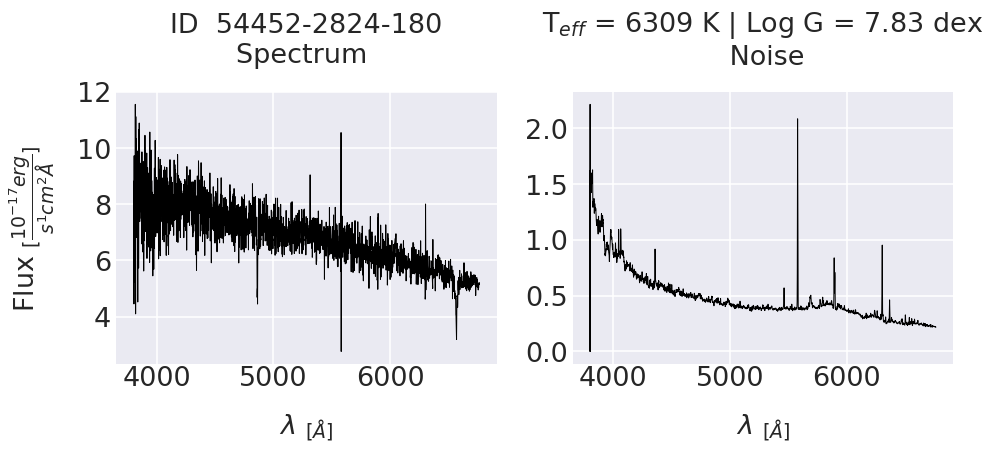

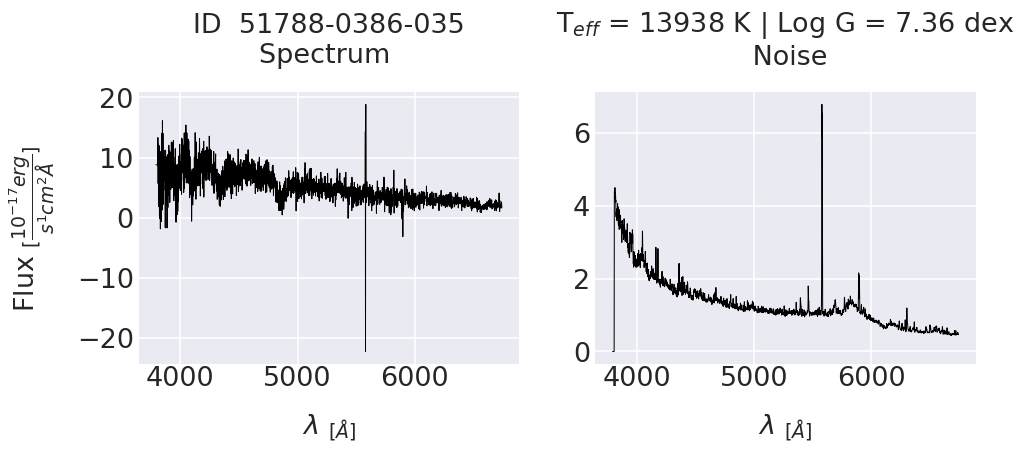

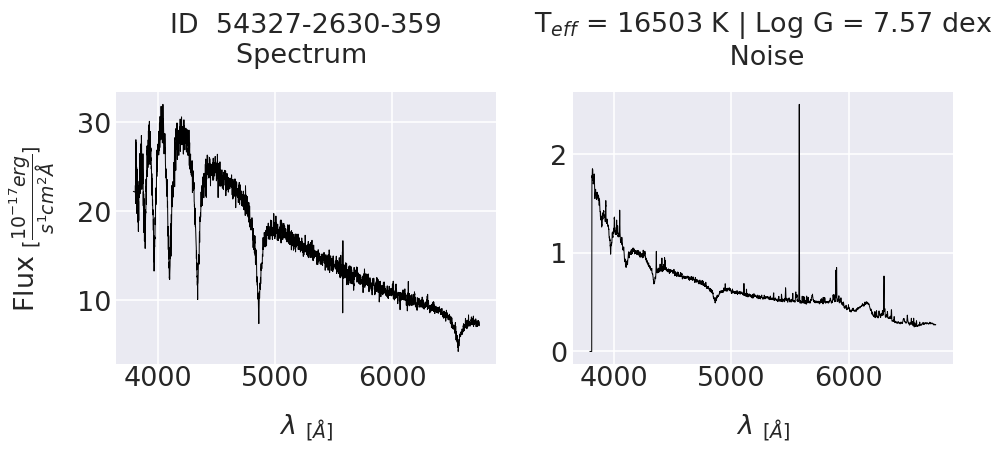

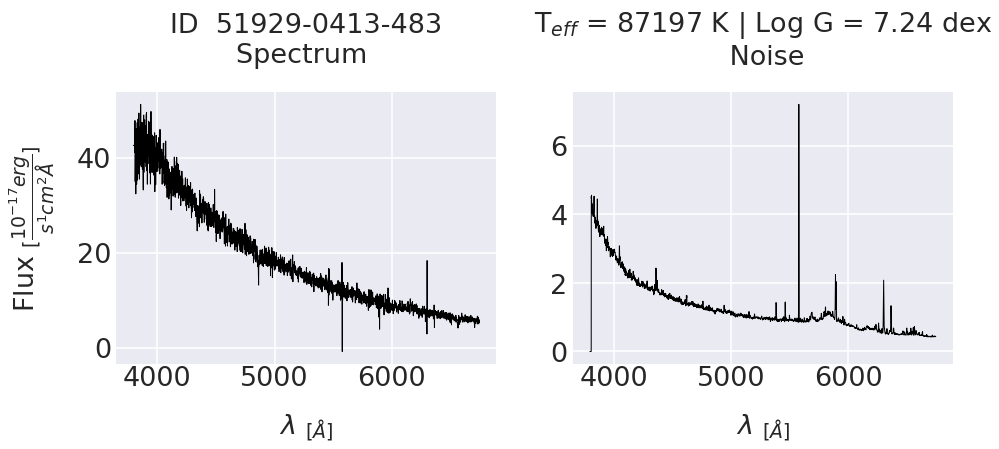

In [105]:
def spectra_noise_plot(i):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    ax[0].plot(data['wavelengths'][i], data['spectra'][i], linewidth = 1, c = 'black')
    ax[0].set_title(f"ID  {data['key'][i]}\nSpectrum ")
    ax[0].set_ylabel('Flux $_{[\dfrac{10^{-17}erg}{s^{1}cm^{2}Å}]}}$')
    ax[0].set_xlabel('$\lambda$ $_{[Å]}$')
    ax[1].plot(data['wavelengths'][i], data['noise'][i],  linewidth = 1, c = 'black')
    ax[1].set_title('T$_{eff}$ = ' + f'{data["Teff"][i]} K | Log G = {data["log_g_"][i]} dex\n Noise')
    ax[1].set_xlabel('$\lambda$ $_{[Å]}$')

    
spectra_noise_plot(18)
spectra_noise_plot(14097)
spectra_noise_plot(9)
spectra_noise_plot(1363)

<pre>
</pre>

_Plot 1: Plot of the spectrum and noise vs. wavelength for four different Kleinman established WD. 1.a represents a low temperature wd. Plot 1.b represents a intermediate temperature wd. Plot 1.c represents a average-high temperature wd. Plot 1.d represents a very high temperature wd._
<pre>
</pre>


__________________________________________________

## 0.2 Data Cleansing
__________________________________________________
<pre>
</pre>

### 0.2.a SNR- and label cuts

The data cleansing is primarily based on the signal-to-noise ratio estimated from the spectra provided in the SDSS database.

<pre>
</pre>

<center> SNR$_{avg} = \dfrac{1}{ N_{pixels}}\sum_i \dfrac{Spectrum_i}{Noise_i}$ </center> 

<pre>
</pre>

To yield sufficient amount of spectra, but still having some restrictions on the ratio, all spectra with SNR < 15 is discharged. Secondary restrictions is made to the estimated errors of the Kleinman labels. The restrictions are applied based on the effects the restrictions have on the final RMS evaluation when the models results are compared to the Kleinman labels. All objects with effective temperature errors larger than 700 K and surface gravitation errors larger than 1 dex are discharged. 


In [106]:
# Estimating SNR value of spectra 
spectra = np.vstack(data['spectra'].values)
spectra_noise = np.vstack(data['noise'].values)
spectra_noise[spectra_noise == 0] = np.nan 

data['SNR'] = [np.nansum(spectra[i]/spectra_noise[i])/len(spectra_noise[i]) for i in range(len(spectra))]  
data['SNR'].describe()

count    14120.000000
mean        11.840127
std          9.252498
min          0.605616
25%          5.383692
50%          9.060315
75%         14.927206
max         89.063325
Name: SNR, dtype: float64

In [107]:
def cleans_data(data):
    data_ = data[data['SNR'] > 15]
    data_ = data_[data_['e_Teff'] < 700]
    data_ = data_[data_['e_log_g_'] < 0.1]
    data = data[(data['Teff'] > 1) & (data['Teff'] > 1)]                                       # Removing all objects without estimates for T or G
    data_ = data_.reset_index()
    #data_['Teff'] = np.log10(data_['Teff'])
    return data_

data_ = cleans_data(data)
data_.describe()

,index,MJD,RAJ2000,DEJ2000,SNg,pm,pmPA,Teff,e_Teff,log_g_,e_log_g_,Mass,e_Mass,SNR
count,3252.000000,3252.000000,3252.000000,3252.000000,3252.000000,3252.000000,3252.000000,3252.000000,3252.000000,3252.000000,3252.000000,3252.000000,3252.000000,3252.000000
mean,7046.077183,53266.883764,171.743424,23.529274,26.321408,46.851107,180.677214,16763.859779,153.410209,8.000387,0.044559,0.570307,0.021621,24.832704
std,4136.397610,933.732070,80.626917,20.465818,9.506243,57.911207,91.664973,8254.200375,118.544506,0.273371,0.018337,0.218689,0.013132,9.366848
min,4.000000,51602.000000,0.095315,-17.889800,14.200000,0.000000,0.000000,6300.000000,2.000000,5.000000,0.002000,0.000000,0.000000,15.006375
25%,3391.000000,52375.000000,127.997240,5.569954,19.160000,13.700000,125.900000,9955.000000,48.000000,7.860000,0.031000,0.536000,0.013000,17.862036
50%,7168.000000,53378.000000,169.684930,21.671479,23.390000,29.900000,188.000000,15368.500000,138.000000,7.970000,0.042000,0.592000,0.019000,21.866461
75%,10462.500000,54153.000000,222.201050,38.348709,30.752500,55.800000,250.150000,21152.250000,221.250000,8.150000,0.055000,0.677000,0.030000,29.019245
max,14118.000000,54653.000000,359.973070,84.197312,89.740000,618.800000,359.900000,76364.000000,694.000000,9.380000,0.099000,1.288000,0.065000,89.063325


In [108]:
spectra = np.vstack(data_['spectra'].values)
wavelengths = np.vstack(data_['wavelengths'].values)
spectra_noise = np.vstack(data_['noise'].values)
BitMask = np.vstack(data_['Bit_Mask'].values)


spectra_noise[spectra_noise == 0] = 1e9

<pre>
</pre>

### 0.2.b Visualization of the cuts

Both the unedited and restricted label space are plotted for the selections of white dwarfs. It is evident that a significant amount of the wd have been discharged. An errorbar plot is also provided for the labels, illustrating the error ranges of the Kleinman labels. In the end a corner plot is provided illustrating some covariance between the parameters.

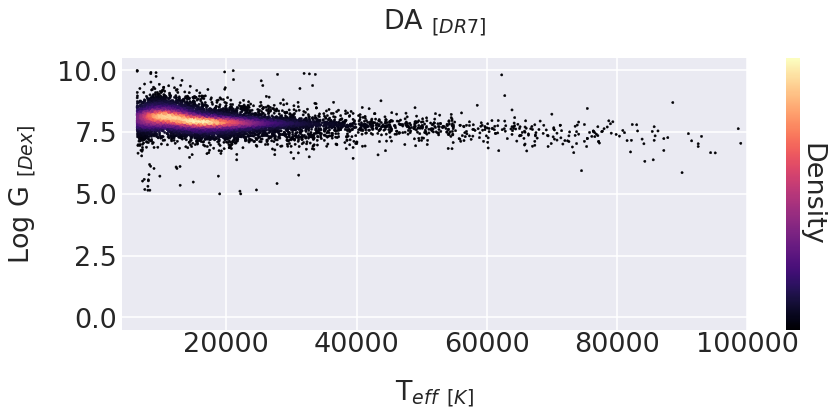

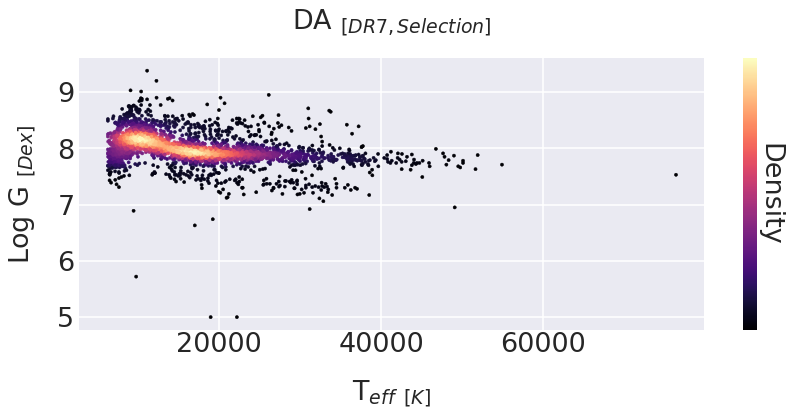

In [109]:
reset_rcParams()

xy = np.vstack([data['log_g_'].values,data['Teff'].values])
z = gaussian_kde(xy)(xy)

plt.figure(figsize = (14,5))
plt.scatter(y = data['log_g_'].values, x = data['Teff'].values, c = z, s = 5, cmap = 'magma')
plt.xlim([4000,100000])
cbar = plt.colorbar()
cbar.ax.set_yticklabels([]) 
cbar.set_label('Density', rotation=270)
cbar.formatter.set_powerlimits((0, 1))
plt.xlabel('T$_{eff}$ $_{[K]}$');
plt.ylabel('Log G $_{[Dex]}$');
plt.title('DA $_{[DR7]}$');

xy = np.vstack([data_['log_g_'].values,data_['Teff'].values])
z = gaussian_kde(xy)(xy)*1e4

plt.figure(figsize = (14,5))
plt.scatter(y = data_['log_g_'].values, x = data_['Teff'].values, c = z, s = 10, cmap = 'magma')
#plt.xticks([20e3,25e3,30e3, 35e3])
#plt.xlim([15e3,40e3])
cbar = plt.colorbar()
cbar.ax.set_yticklabels([])  
cbar.set_label('Density', rotation=270)

plt.xlabel('T$_{eff}$ $_{[K]}$');
plt.ylabel('Log G $_{[Dex]}$');
plt.title('DA $_{[DR7,  Selection]}$');

<pre>
</pre>

_Plot 2: Plot 2.a shows the labels of all DA WD found in the Kleinman catalouge, colored by the density distribution of 14.120 WD. Plot 2.b Shows the selected 3252 DA WD based on cuts in SNR and label errors._

<pre>
</pre>

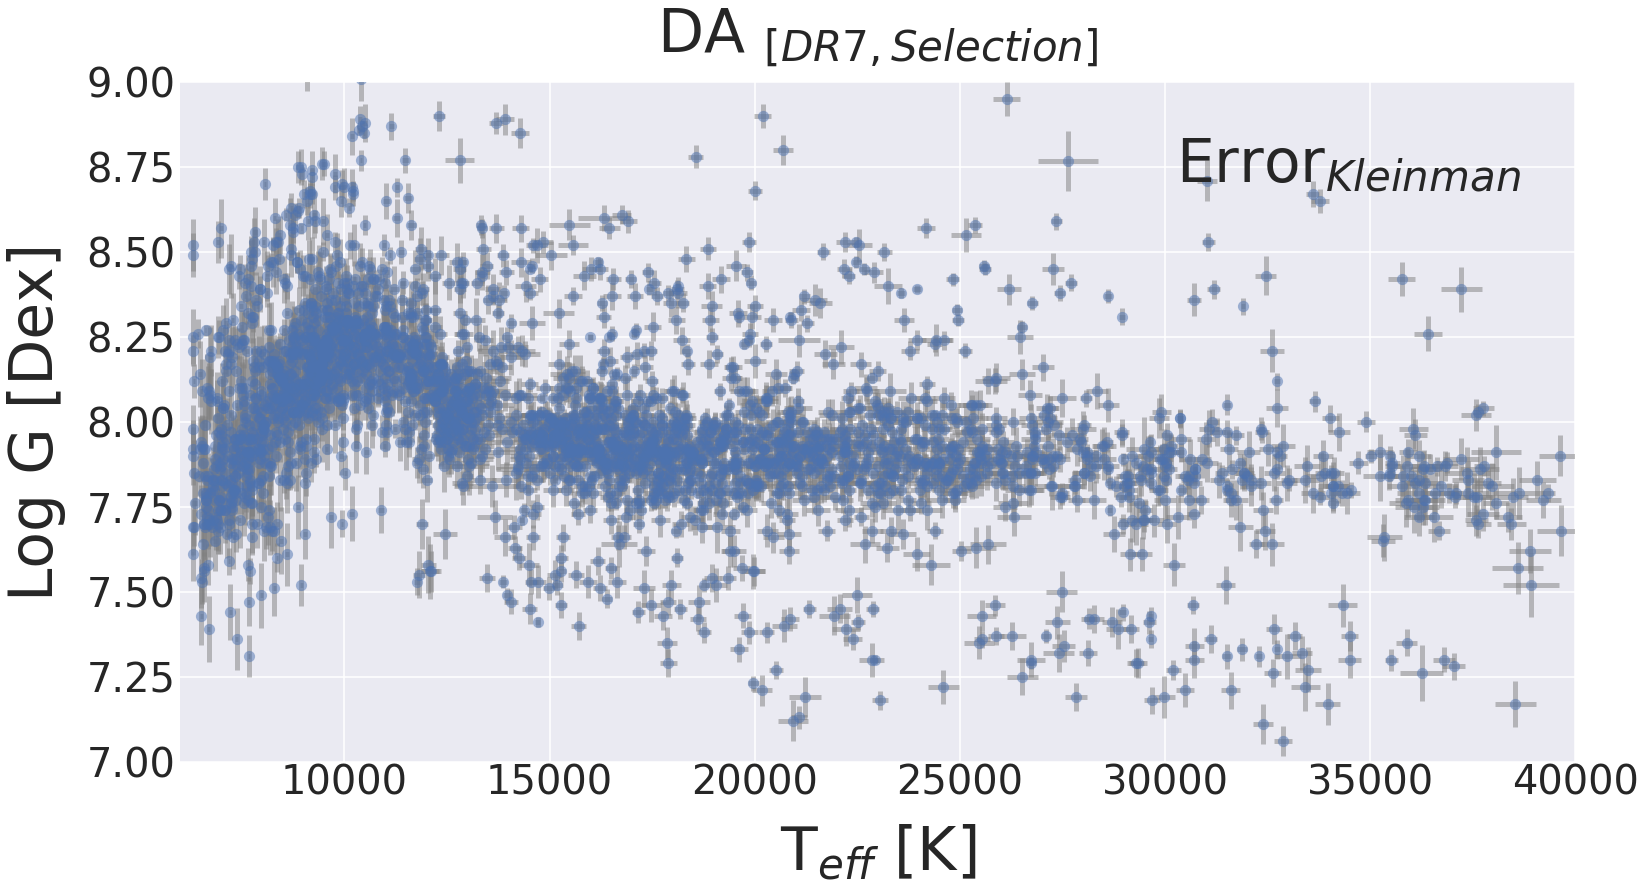

In [110]:
plt.figure(figsize = (25,12.5))

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)#, rotation=90)

plt.errorbar( y = data_['log_g_'].values,  x = data_['Teff'].values , alpha = 0.5, yerr = data_['e_log_g_'].values, xerr= data_['e_Teff'].values, fmt='o',
             ecolor='gray', elinewidth = 5, capsize= 5)


plt.xlabel('T$_{eff}$ [K]', fontsize = 60)
plt.ylabel('Log G [Dex]', fontsize = 60)
plt.title('DA $_{[DR7,  Selection]}$', fontsize = 60)
plt.legend(['Error$_{Kleinman}$'], fontsize = 60)
plt.ylim([7,9])
plt.xlim([6000,40000])

plt.show()

_Plot 3: Plot of the Kleinman errorbars in the labels used to build the model._

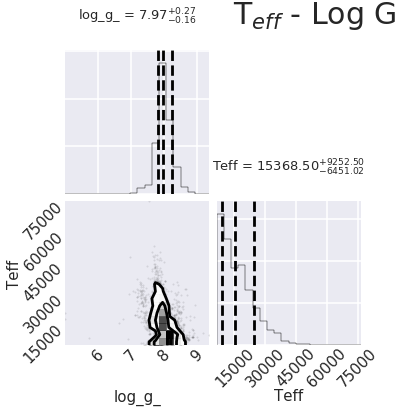

In [111]:
adjust_rcParams(30, 0.5,100,0)

figure = corner.corner(data_[['log_g_','Teff']],
                       quantiles=[0.16, 0.5, 0.84],
show_titles=True, title_kwargs={"fontsize": 13
                               });
figure.gca().annotate("T$_{eff}$ - Log G",
                      xy=(1.0, 1.0), xycoords="figure fraction",
                      xytext=(0, 0), textcoords="offset points",
ha="right", va="top");

_Plot 4: Corner plot of the two Kleinman labels for all wd._

### 0.2.c Bitmask application to error estimates

Every SDSS spectrum comes with a bitmask, a representation that keeps track of whether certain conditions are met in regards to the quality of every pixel. The conditions are tracked as bits following a binary representation of an integer, in a bitmask-encoded value called _flags_. The binary system will then unambiguously describe the status of each pixel. See the appendix for a full overview of the binary representation.

For the wavelengths where the bad pixels are found, the error of the spectrum is turned to a large value so that these pixels will contribute a minimum to the likelihood function when weighted in the model. As a first attempt at cleaning the spectra the badpix value is set to be equal to 1073741824. From there on the value is regulated to test if additional bits alter the result significantly. After some trial and error running through the code a total of 4 combinations are selected. Furthermore, the error is significantly increased where the spectrum is found to be equal to or less than zero. A plot is provided to illustrate how the bitmasks alternate the error spectra, who is later to be used as weights when building the model. Pixels where the conditions are met through the bitmask will thus have a reduced contribution to the model. 


In [112]:
def bitmask_adjustments(spectrum, bitmask):
    """ Adjusting uncertainties 
    """
    bolean_zeros_removal  = [(spectrum[i] == 0) for i in range(len(spectrum))]
    val_zeros             = np.array([10**8*bolean_zeros_removal[i] for i in range(len(spectrum))]);
    
    bolean_neg_removal  = [(spectrum[i] < 0) for i in range(len(spectrum))]
    val_neg             = np.array([10**8*bolean_neg_removal[i] for i in range(len(spectrum))]);

    # Set uncertanties high from bitmask
    binary_badpx          =  1073741824  #2**1 + 2**2 + 2**3 + 2**4 + 2**5 + 2**6 + 2**7 + 2**12
    bolean_badpix_filter  = [(bitmask[i] & binary_badpx) != 0 for i in range(len(bitmask))]
    
    binary_badpx2          =  142606336  #2**1 + 2**2 + 2**3 + 2**4 + 2**5 + 2**6 + 2**7 + 2**12
    bolean_badpix_filter2  = [(bitmask[i] & binary_badpx2) != 0 for i in range(len(bitmask))]
    
    binary_badpx3          =  8388608  #2**1 + 2**2 + 2**3 + 2**4 + 2**5 + 2**6 + 2**7 + 2**12
    bolean_badpix_filter3  = [(bitmask[i] & binary_badpx3) != 0 for i in range(len(bitmask))]
    
    binary_badpx4          =  2**24  # 
    bolean_badpix_filter4  = [(bitmask[i] & binary_badpx4) != 0 for i in range(len(bitmask))]
    
    val_badpix            = np.array([10**8*bolean_badpix_filter[i] for i in range(len(bitmask))]);
    val_badpix2          = np.array([10**8*bolean_badpix_filter2[i] for i in range(len(bitmask))]);
    val_badpix3          = np.array([10**8*bolean_badpix_filter3[i] for i in range(len(bitmask))]);
    val_badpix4          = np.array([10**8*bolean_badpix_filter4[i] for i in range(len(bitmask))]);
    
    error                 = val_badpix + val_badpix2 + val_badpix3  +val_zeros + val_neg + val_badpix4
    
    return error


bitmask_edit = bitmask_adjustments(spectra,  BitMask.astype(int))    

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


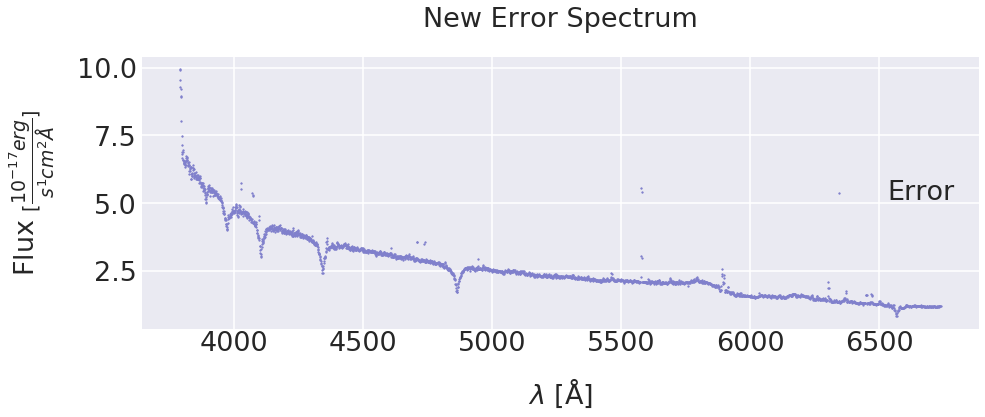

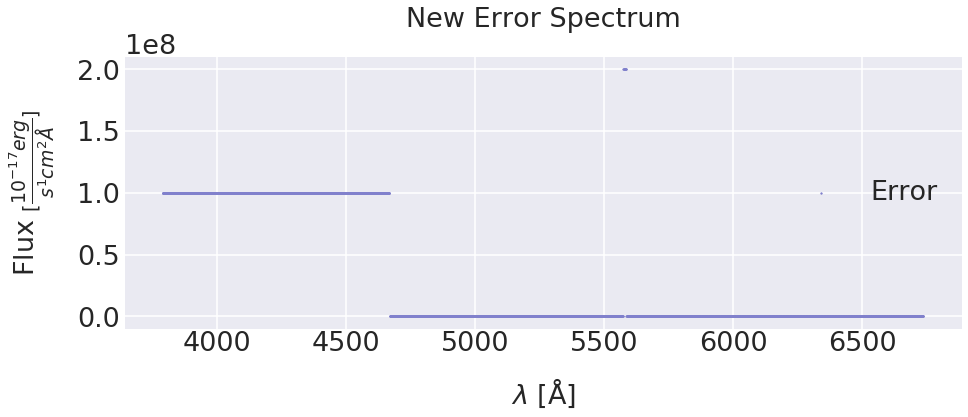

In [113]:
def plot_new_error(index):
    reset_rcParams()
    plt.figure(figsize = (15,5));
    plt.scatter(wavelengths[index],spectra_noise[index], s = 3, c = (0.5,0.5,0.8));
    plt.xlabel('$\lambda$ [Å]');
    plt.ylabel('Flux $_{[\dfrac{10^{-17}erg}{s^{1}cm^{2}Å}]}}$')
    plt.legend(['Error'], loc = 'right')
    plt.title('New Error Spectrum');

    plt.figure(figsize = (15,5));
    plt.scatter(wavelengths[index],bitmask_edit[index], s = 3, c = (0.5,0.5,0.8));
    plt.xlabel('$\lambda$ [Å]');
    plt.ylabel('Flux $_{[\dfrac{10^{-17}erg}{s^{1}cm^{2}Å}]}}$')
    plt.legend(['Error'], loc = 'right')
    plt.title('New Error Spectrum');

plot_new_error(42)

_Plot 5: 5.a shows the error spectrum before adjustments, and 5.b shows the how taking the bitmasks into account significantly alter the error spectrum._

## 0.3 Psudo-Continuum Normalization

The Cannon model that this article intends to construct assumes that all spectra are continuum-normalized in a consistent way. As well, it assumes that the spectra are sampled on a consistent rest-frame wavelength grid, with the same line-spread function, like stated by Ness et al [Ness et Al, 2015]. The inention behind the psudo-normalization is further described in the appendix. 

In order to preforme an approximation to the continuum, I attempt to locate the most evident absorption lines  across all spectra. This is done primearly by eye estimation, but also by taking special concideration to the theoretical expectation of where the Balmer line should lie. For instance

| __Name of Line__   | __n$_f$__  | __n$_i$__  | __Wavelength [Å]__  |   
|---|---|---|---|
| Balmer Alpha  | 2  |  3 | 6561  |   
| Balmer Beta  |  2 |  4 | 4861  |   
| Balmer Gamma  | 2  |  5 |  4341 |   
| Balmer Delta  | 2  | 6  | 4102  |   


Based on the findings an array is formulated containing the index of all pixels that are concidered to not be significantly affected by deep absroption lines. A polynomial of the 5$^{th}$ degree is then fitted to the spectra projected onto the good pixel values. A fifth degree polynomial is selected as it is found to seemingly best fit the range of spectra, and minimise the rms value of the end results. The spectra is then divided by this curve-fit to preforme a psudo-continuum normalization. The error estimations from the bitmasks are then appended to the psudo-normalized errors. 

An example of the un-normalized spectrum, the derived pseudo-continuum and the normalized version of the spectrum are plotted for two random spectra. 

In [114]:
def continuum_normalisation(spec):
    cn_spec = []
    curve_ = []
    noise_ = []
    
    for i in trange(len(spec)):
        good_pxl = [i for i in range(20,80,1)]  + [i for i in range(130,170,1)] +  [i for i in range(230,280,1)] + [i for i in range(400,500,1)]+ [i for i in range(625,1025,1)] +  [i for i in range(1100,1650,1)] +  [i for i in range(1700,2325,1)] +  [i for i in range(2425,2499,1)] #+ [i for i in range(3800, len(spec[0]),1)]

        idx = [i for i in range(len(spec[i]))]
        grid = np.take(spec[i],good_pxl)
        
        coeff = np.polyfit(good_pxl, grid,5)
        curve = np.polyval(coeff, idx)
    
        cn_spec.append(spec[i]/curve)
        noise_.append(spectra_noise[i]/curve)
        curve_.append(curve)

    return cn_spec, curve_, noise_

        
cn_spec, curve, cn_spec_err = continuum_normalisation(spectra)
cn_spec, cn_spec_err = np.array(cn_spec), np.array(cn_spec_err)
cn_spec_err = cn_spec_err + bitmask_edit


d = {'cn_spec': np.ndarray.tolist(cn_spec), 'cn_spec_err': np.ndarray.tolist(cn_spec_err), 'key': data_['key']}
df = pd.DataFrame(d)
data_ = pd.merge(data_, df, on =  'key')


100%|██████████| 3252/3252 [00:03<00:00, 1068.15it/s]


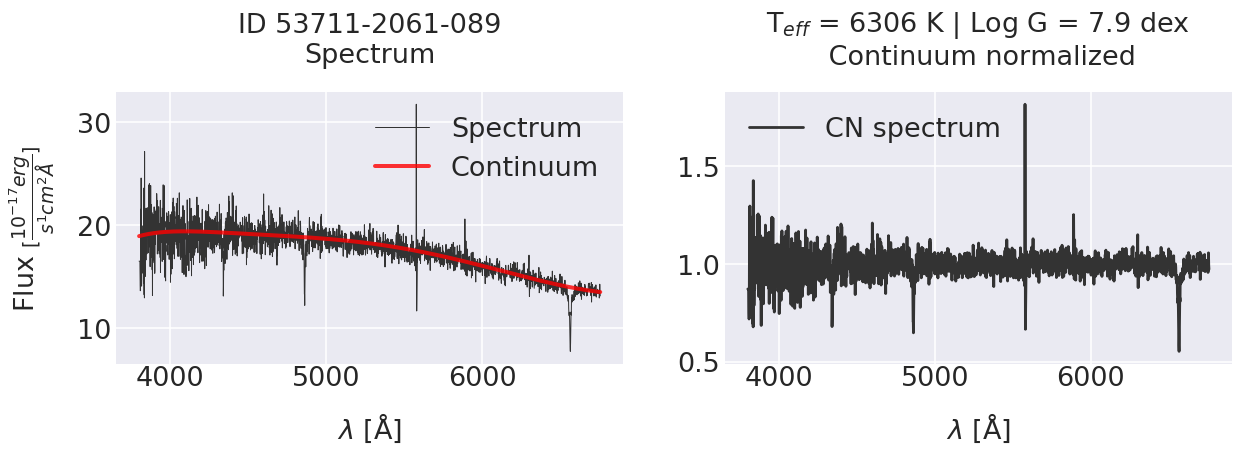

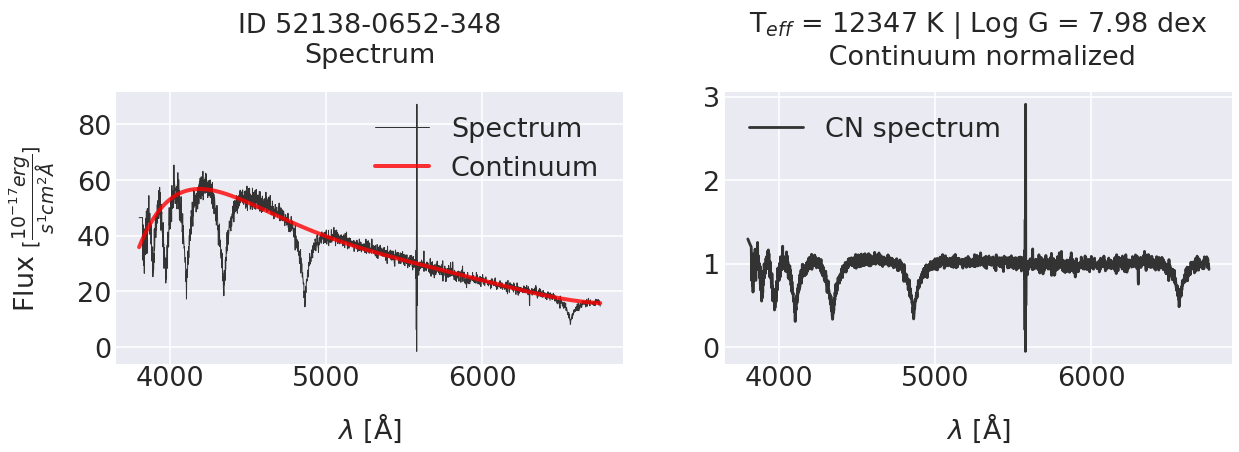

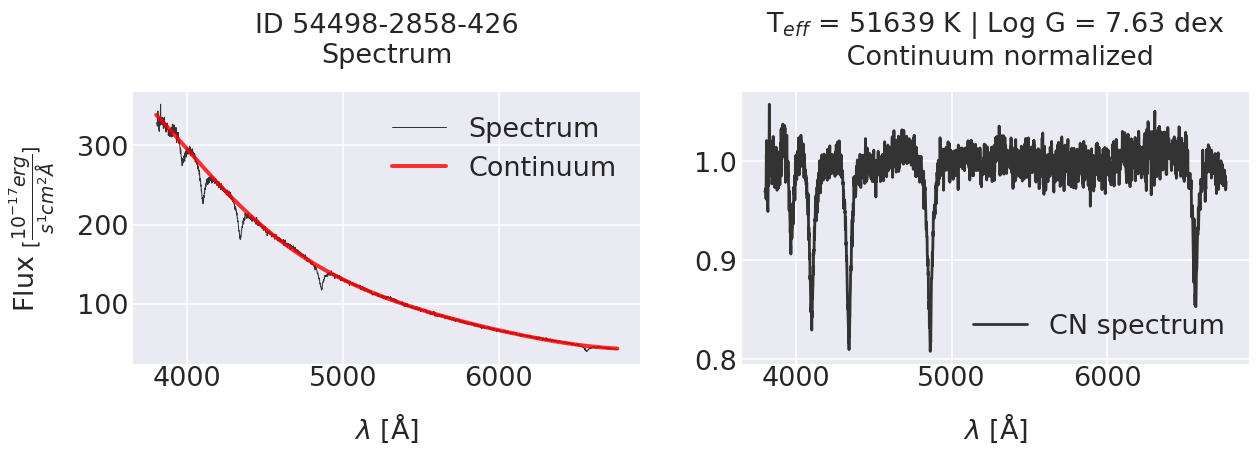

In [115]:
def sub_plot_spectrum(index):
    fig = plt.figure(figsize=(20, 5))
    ax = fig.add_subplot(1, 2, 1);
    #ax.grid()
    plt.plot(wavelengths[index], spectra[index], linewidth = 1, c = (0.2,0.2,0.2))
    plt.plot(wavelengths[index], curve[index], c = 'r', alpha = 0.8, linewidth = 4)
    plt.legend(['Spectrum','Continuum'])
    plt.ylabel('Flux $_{[\dfrac{10^{-17}erg}{s^{1}cm^{2}Å}]}}$')
    plt.xlabel('$\lambda$ [Å]')
    plt.title(f'ID {data_["key"][index]}\nSpectrum');

    ax = fig.add_subplot(1, 2, 2);
    #ax.grid()
    plt.plot(wavelengths[index], cn_spec[index], c = (0.2,0.2,0.2),label = 'Normalized')
    plt.xlabel('$\lambda$ [Å]')
    plt.legend(['CN spectrum'])
    plt.title('T$_{eff}$ = ' + f'{data_["Teff"][index]} K | Log G = {data_["log_g_"][index]} dex\n Continuum normalized');

reset_rcParams()
sub_plot_spectrum(160)
sub_plot_spectrum(28)
sub_plot_spectrum(1640)


_Plot 6: 3 different spectra, their continuum-curve fit and the psudo-continuum normalized curve illustrating the normalization across the range of T._

### 0.4 Discussion and Evaluation of available Data

It is clear that the available WD exhibit a wide range of temperatures, and some variations of the surface gravitation. 
Looking at the spectra plotted both in figure 1 and figure 6, there is clearly a large variation in the appearance of the spectra following the variations in T$_{eff}$. It is evident that there is a lack of Balmer lines for both the cold and very hot white dwarfs. There are some absorption lines present in the intermediate region, and there are clear absorption/Balmer lines present in the normally hot white dwarf spectra. One can see that both the very high and low temperature spectra has a lack of any clear distinguishable features. This is due to that in the low temperature regime there is not enough energy to excite the electrons to the first excited statet, while in the high temperature regime the hydrogen is all ionized.

The lack of distinguishable features might cause issues in regards to the pseudo-normalization. When the continuum is removed from the spectra, a very hot dwarf might easily be confused with the spectra of a cold white dwarf. More plots of the spectra and the normalized-spectra can be found in the appendix, to further illustrate the variations and similarities of all spectra. 



## 1.0 Building a WD model

The model initially applied here under is based on the Cannon constructed by [Ness et al, 2015](https://arxiv.org/abs/1501.07604). 

To create a model able to predict the labels as a function of each spectra, we need a training set and a set to test our model on. Therefore the set of 3252 stars are divided into two groups of 1626 stars each, called the training- and the cross_validation set. All stars have spectra is mapped onto a 2500 pixels. The selection is done at random by the sklearn module. The shuffle seems necessary in order to avoid any potential hidden covariances in the set. For reproducibility sake a seed is placed as random_state = 42.

Initially, a second order polynomial is chosen to fit the model. Therefore a 780x6 label matrix is constructed, containing rows for each of the 824 stars with columns that are quadratic in the labels:

<center> $\vec{l}_n = \begin{bmatrix}1 & T_{eff} & Log_G & T_{eff}^2 &  Log_G^2 & T_{eff}Log_G\\
\end{bmatrix}$</center>

Both labels are scaled to unity using the standard scaler of sklearn.preprocessing.


In [116]:

def expand_labelset(data_):
    scaler = StandardScaler()
    ASPCAP_labels = np.asmatrix([data_['Teff'].values, data_['log_g_'].values] ).T
    scaler.fit(ASPCAP_labels)
    scaled_data = scaler.transform(ASPCAP_labels)

    ASPCAP_labels_ERR = np.asmatrix([data_['e_Teff'].values, data_['e_log_g_'].values] ).T

    N_labels = 6
    labels = np.zeros((len(cn_spec), N_labels))

    labels[:,0] = np.ones(len(cn_spec))
    labels[:,1] = scaled_data[:,0]
    labels[:,2] = scaled_data[:,1]

    labels[:,3] = labels[:,1]**2
    labels[:,4] = labels[:,2]**2

    labels[:,5] = labels[:,1]*labels[:,2]
    return labels, ASPCAP_labels_ERR, scaler, ASPCAP_labels

## 1.1 Constructing a probabilistic generativ model

Having prepared a training set, the next step is to build a spectral model that predicts a spectrum at every wavelength pixel as a function of the selected labels. 

A generative spectral model is then inferred from the spectra and stellar labels of a selection of reference objects. I.e a model that constructs, as a function of labels, a probability density function for the observed flux as a function of wavelengths. 

The model is built upon the two basic notions as laid out by Ness et al:

1. _The continuum-normalized spectra of stars with identical labels look near identical at every pixel_
2. _The expected flux at every pixel changes continuously with changes in the labels_
    
As Ness et al states, looking away from the observational errors and intrinsic scattering, assumption 1 is true if the set of labels are exhaustive. I.e our model built upon 2 different labels must necessarily be an approximation to the full spectra inferred from an exhaustive label set. 

It is assumed that the spectral model can be characterized by a set of coefficients that allows to predict the flux at every pixel for a given label vector. Thus, the training set is used to derive a coefficient matrix $\vec{\Theta}_{\lambda}$ containing 6 coefficient for each label across all pixels. The first pixel is included to yield a linear offset in the fitting. The fitting is done by using a least squares method implemented in the numpy function _linalg.lstsq(labels, spectra)_. That is, solving for $\vec{\Theta}_{\lambda}$ in the expected flux relation:

<center>$f_{n,\lambda} = \vec{\Theta}_{\lambda}^T \cdot \vec{l}_n$ + noise</center>

The model will in the end be probabilistic and produce for every object spectrum at every wavelength, a pdf for the flux, with an expectation value and variance. 

Two additional features are applied while building the model. First the spectra are scaled by removing the mean and scaling to unit variance. This is done in the section above. Secondly, pixels with large uncertainties are down-weighted when training the model by applying the weights and solving for:


<center> $\vec{l}_n^TWf_{n,\lambda} = \vec{\Theta}_{\lambda}^T \cdot (\vec{l}_n^TW\vec{l}_n)$</center>

Where $W = 1/\sigma^2$ and $\sigma$ is the error matrix of all pixels in all spectra. 

The model is overplotted the training spectra to yield a closer look on how good the fit actually is. 

In [117]:
def build_model(f, X, sigma):
    sigma[sigma == 0] = 1e6
    W = 1/sigma**2
    coeff = np.zeros((N_labels,N_pixels))
    for i in trange(N_pixels):
        weight = np.diag(W[:,i])
        
        WA = np.matmul(X.T,np.matmul(weight,X))
        WB = np.matmul(X.T,np.matmul(weight,f[:,i]))
        
        coeff[:,i] = np.linalg.lstsq(WA,WB)[0]
    return coeff

In [118]:
def build_spectra(theta, labels):
    
    labels_full = np.zeros((1, N_labels))
    labels_full[:,0] = 1
    labels_full[:,1:3] = labels
    labels_full[:,3] = labels_full[:,1]**2
    labels_full[:,4] = labels_full[:,2]**2
    
    labels_full[:,5] = labels_full[:,1]*labels_full[:,2]
   
    
    return np.dot(theta,labels_full.T)

In [119]:
def ln_like(labels, y, err):
    inv_sigma2                  = 1.0/(err**2)
    model = build_spectra(theta.T, labels).T[0]
    P_nl = 0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(inv_sigma2)))
    return P_nl

def model():
    results =  np.zeros((len(y_test), 2))
    for i in trange(len(y_test)-3):
        results[i,:] = minimize(ln_like, np.ones(2), args = (y_test[i], err_test[i]), method = 'L-BFGS-B').x
    return results



## 2. Application of the model

In this section the model is applied to various ranges of the data, in order to probe for information about the assumed model and the WD spectra. 


### 2.1.a Initial test - All temperatures

Initially the model is trained on half of all the available spectra, that is 1626 wd, and then applied to the reaming half for evaluation. The model is over-plotted a spectrum to look at how well the model preforms. The values of the RMS, bias and scatter are provided. Then, the estimated labels are plotted alongside the Kleinman estimates to evaluate the correspondence. 

In [120]:
data_T = data_[data_['Teff'] > 1]
cn_spec  =  np.vstack(data_T['cn_spec'])             
cn_spec_err = np.vstack(data_T['cn_spec_err'] )

labels, ASPCAP_labels_ERR, scaler, ASPCAP_labels = expand_labelset(data_)
ID_train, ID_test, labels_train, labels_test, labels_err_train, labels_err_test ,err_train, err_test, y_train, y_test, labels_unscaled_train,labels_unscaled_test = train_test_split(data_['key'], labels, ASPCAP_labels_ERR, cn_spec_err,  cn_spec, ASPCAP_labels, test_size=0.5, random_state=42)
N_test, N_labels, N_pixels = len(y_test), 6, len(y_test[0])

theta = build_model(y_train, labels_train, err_train)

model_trained_data = np.matmul(theta.T, labels_train.T).T



model_of_test = model()

Estimator = scaler.inverse_transform(model_of_test)
Apstar = scaler.inverse_transform(labels_test[:,1:3])

100%|██████████| 1623/1623 [00:14<00:00, 112.90it/s]


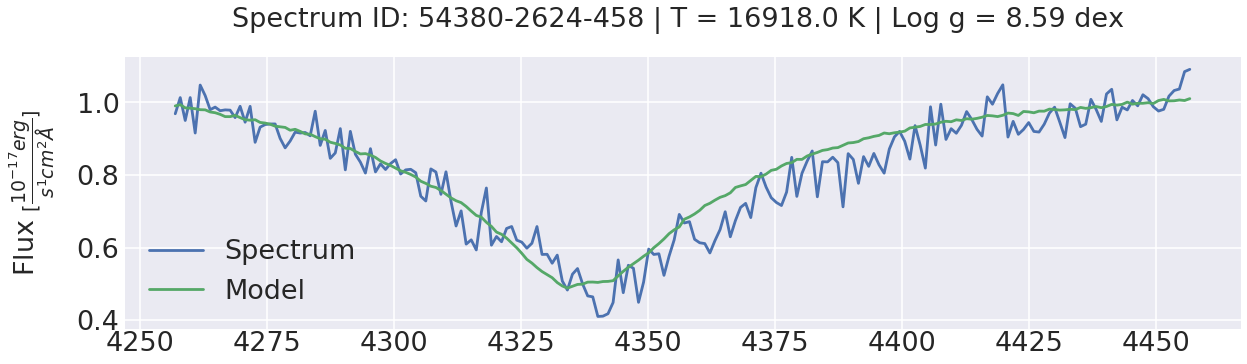

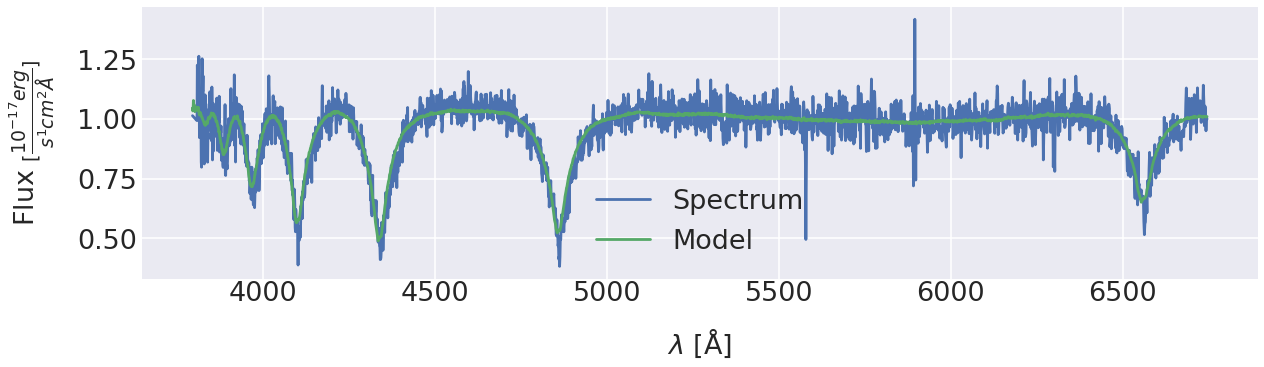

In [121]:
def plot_train_model(index):
    reset_rcParams()
    plt.figure(figsize = (20,5))
    plt.plot(wavelengths[index][500:700], y_train[index][500:700])
    plt.plot(wavelengths[index][500:700],model_trained_data[index][500:700])
    plt.ylabel('Flux $_{[\dfrac{10^{-17}erg}{s^{1}cm^{2}Å}]}}$')
    plt.legend(['Spectrum', 'Model'],  loc = 'best')
    plt.title(f'Spectrum ID: {ID_train[index]} | T = {labels_unscaled_train[index,0]} K | Log g = {labels_unscaled_train[index,1]} dex ')

    plt.figure(figsize = (20,5))
    plt.plot(wavelengths[index], y_train[index])
    plt.plot(wavelengths[index], model_trained_data[index])
    plt.ylabel('Flux $_{[\dfrac{10^{-17}erg}{s^{1}cm^{2}Å}]}}$')
    plt.xlabel('$\lambda$ [Å]')
    plt.ylabel('Flux $_{[\dfrac{10^{-17}erg}{s^{1}cm^{2}Å}]}}$')
    plt.xlabel('$\lambda$ [Å]')
    plt.legend(['Spectrum', 'Model'], loc = 'best')
    
plot_train_model(10)

_Plot 7: All avilable spectra is used. 7.a shows a zoomed version of the model-spectra comparison in a model fit across the entire range of effective temperature. 7.b shows a broader version of the same spectra, that illustrates how the model tends to follow the general outlines of the spectra across all avilable wavelengths._

In [122]:
def error(true_spectrum, model_spectrum,label, unit):
    rms     = np.sqrt(np.sum((true_spectrum-model_spectrum)**2)/(len(true_spectrum)-1))
    bias    = 1/len(true_spectrum)*np.sum(true_spectrum-model_spectrum)
    scatter = np.round(np.std(true_spectrum-model_spectrum),5)
    print('\n')
    print("RMS        ", label,":   ",round(rms,3), unit)
    print("Bias       ", label,":   ", round(bias,3), unit)
    print('Scatter    ', label,':   ', round(scatter,3), unit)
    print('------------------------------------')
    return rms, bias, scatter

rms_T, bias_T, scatter_T = error(Apstar[:,0], Estimator[:,0], 'T_eff ', ' [K]')
rms_G, bias_G, scatter_G = error(Apstar[:,1], Estimator[:,1], 'Logg G', " [dex]")




RMS         T_eff  :    13393.3  [K]
Bias        T_eff  :    -7275.364  [K]
Scatter     T_eff  :    11240.073  [K]
------------------------------------


RMS         Logg G :    0.371  [dex]
Bias        Logg G :    0.013  [dex]
Scatter     Logg G :    0.371  [dex]
------------------------------------


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


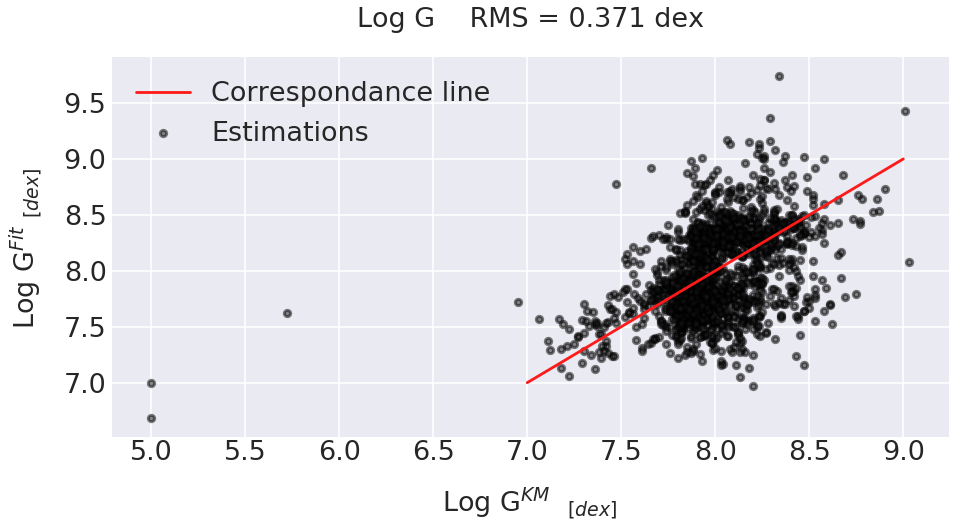

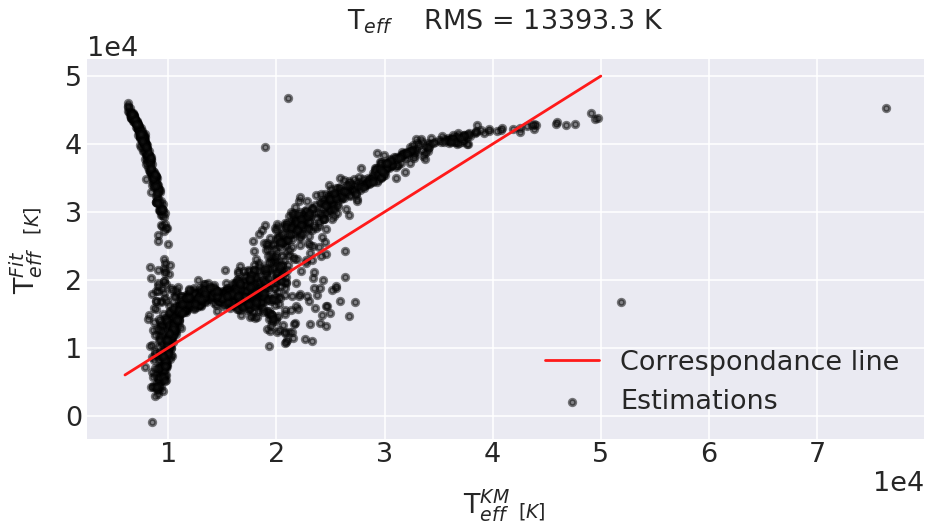

In [123]:
def plot_compar2(line_g_x, line_g_y, line_T_x, line_T_y):
    plt.figure(figsize = (15,7));
    plt.plot(line_g_x, line_g_y, c = (1.0,0.1,0.1))
    plt.scatter(Apstar[:,1], Estimator[:,1], s = 40, c = (0.1,0.1,0.1), alpha = 0.5, edgecolor='black', linewidth='3')
    plt.xlabel('Log G$^{KM}$  $_{[dex]}$');
    plt.ylabel('Log G$^{Fit}$ $_{[dex]}$ ');
    plt.title(f'Log G    RMS = {rms_G:.3f} dex')
    plt.legend(['Correspondance line', 'Estimations'])

    
    plt.figure(figsize = (15,7));
    plt.scatter(Apstar[:,0], Estimator[:,0], alpha = 0.5, s = 40, c =  (0.1,0.1,0.1), edgecolor='black', linewidth='3')
    plt.xlabel('T$_{eff}^{KM}$ $_{[K]}$ ');
    plt.ylabel('T$_{eff}^{Fit}$  $_{[K]}$ ');
    plt.plot(line_T_x,line_T_x, c = (1.0,0.1,0.1))
    plt.title('T$_{eff}$  '+f'  RMS = {rms_T:.1f} K')
    plt.ticklabel_format(style='sci', scilimits=(0,0))
    plt.legend(['Correspondance line', 'Estimations'])
    
    
    
plot_compar2([7,9],[7,9], [6e3, 50e3],[6e3, 50e3])

_Plot 8: All available spectra is used. Plot 8.a shows the correspondence between the models estimated values for the surface gravitation and the Kleinman Log g. Plot 8.b shows the correspondence between the models estimated values for the effective temperature and the Kleinman effective temperature._

### 2.1.b Evaluation of model - All temperatures

Plot 7 is a plot of the model to a random spectrum. It shows that the model tends to follow the general outline but fails in completely matching the spectrum. This might be an indication that the model is not optimal, but on the other hand it might also be simply an indication on high, insignificant noise rates. 

Plot 8 shows the correspondence plots. The results appears to be quite poor, but it has some very interesting general outlines. For instance, the model tends to fit bifurcate at low temperatures but has a higher level of consistency as the temperature increases. The Log g correspondence also appears to be very poor, as the RMS value almost indicates randomness. It is although evident that you also here are able to spot a slight branching in the fit. 


### 2.2.a Application in high T limit

Since the model appears to fit more consistently at higher temperatures, it is tempting to apply the model solely to this region. An attempt is made at fitting the model to the region T = [15500, 40000] K. Thus excluding the hottest wd that might cause some issues due to the similarity they might have to the cold wd normalized spectra. 

In [124]:
data_high_T = data_[(data_['Teff'] > 15500) & (data_['Teff'] < 40000)]
cn_spec  =  np.vstack(data_high_T['cn_spec'])             
cn_spec_err = np.vstack(data_high_T['cn_spec_err'] )
spectra = np.vstack(data_high_T['spectra'])

labels, ASPCAP_labels_ERR, scaler, ASPCAP_labels = expand_labelset(data_high_T)
ID_train, ID_test, labels_train, labels_test, labels_err_train, labels_err_test ,err_train, err_test, y_train, y_test, labels_unscaled_train,labels_unscaled_test = train_test_split(data_high_T['key'], labels, ASPCAP_labels_ERR, cn_spec_err,  cn_spec, ASPCAP_labels, test_size=0.5, random_state=42)
N_test, N_labels, N_pixels = len(y_test), 6, len(y_test[0])

theta = build_model(y_train, labels_train, err_train)

model_trained_data = np.matmul(theta.T, labels_train.T).T



model_of_test = model()

Estimator = scaler.inverse_transform(model_of_test)
Apstar = scaler.inverse_transform(labels_test[:,1:3])

100%|██████████| 778/778 [00:05<00:00, 146.69it/s]


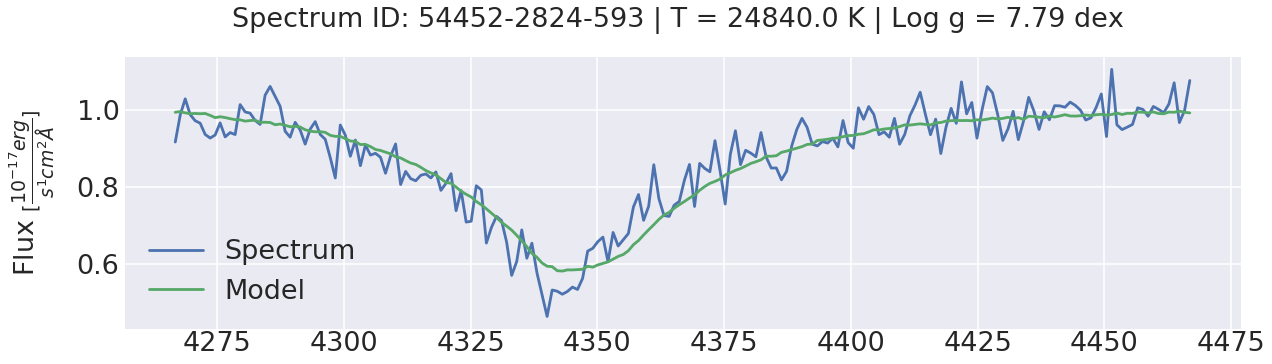

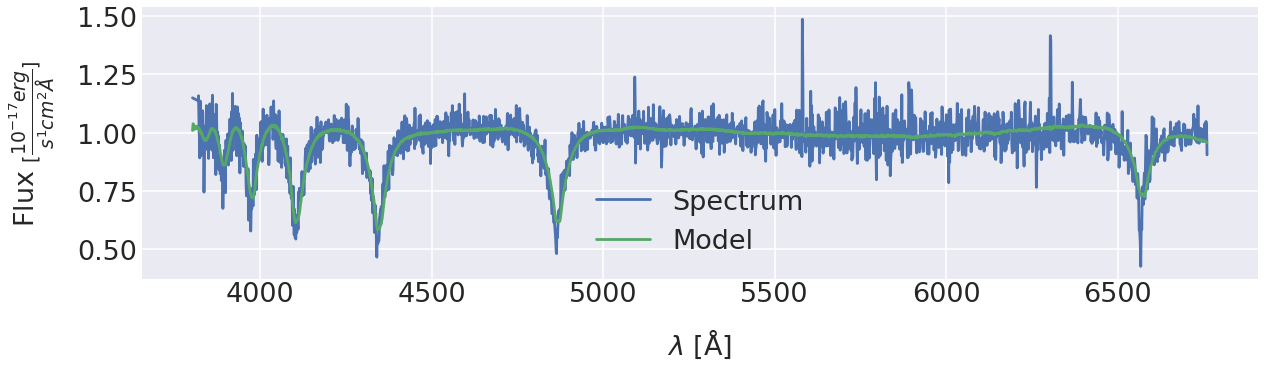

In [125]:
plot_train_model(12)

_Plot 9: Only intermediate temperature spectra is used. 9.a shows a zoomed version of the model-spectra comparison in a model fit across the entire range of effective temperature. 9.b shows a broader version of the same spectra, that illustrates how the model tends to follow the general outlines of the spectra across all avilable wavelengths._

In [126]:
rms_T, bias_T, scatter_T = error(Apstar[:,0], Estimator[:,0], 'T_eff ', ' [K]')
rms_G, bias_G, scatter_G = error(Apstar[:,1], Estimator[:,1], 'Logg G', " [dex]")



RMS         T_eff  :    1520.404  [K]
Bias        T_eff  :    -108.71  [K]
Scatter     T_eff  :    1515.536  [K]
------------------------------------


RMS         Logg G :    0.221  [dex]
Bias        Logg G :    -0.012  [dex]
Scatter     Logg G :    0.221  [dex]
------------------------------------


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


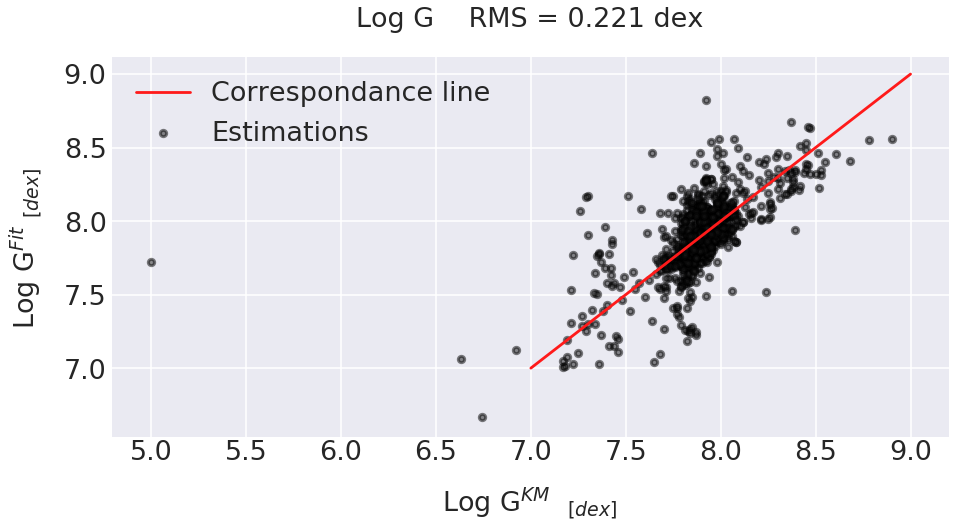

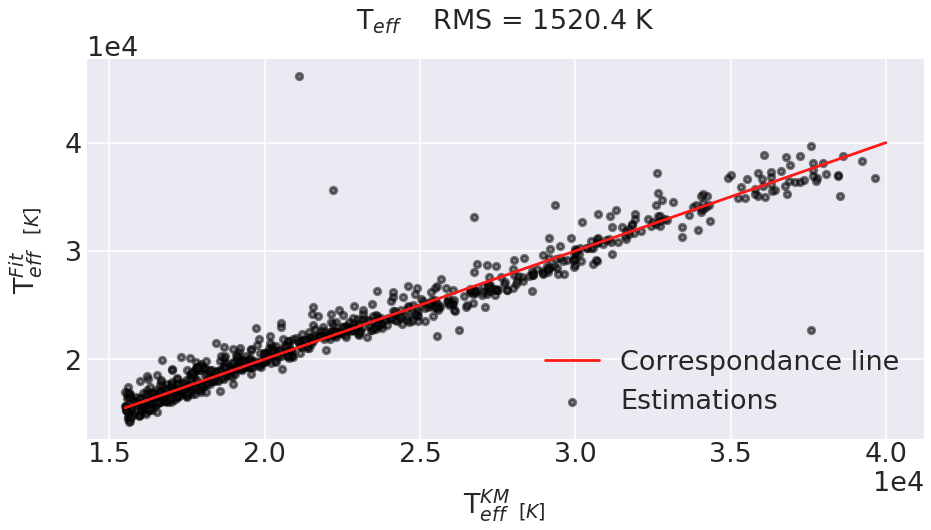

In [127]:
plot_compar2([7,9],[7,9], [15.5e3, 40e3],[15.5e3, 40e3])

_Plot 10: Only intermediate temperature spectra are used. Plot 10.a shows the correspondence between the models estimated values for the surface gravitation and the Kleinman Log g. Plot 10.b shows the correspondence between the models estimated values for the effective temperature and the Kleinman effective temperature._

### 2.2.b Evaluation of model - High temperatures

By the look of plot 9, the model seems to fit slightly better than in plot 7. It follows the general outlines, but also appears to have gained a slightly leftward displacement in regards to the actual spectra. Looking at the correspondence plot on the other hand, reveals that the model preforms vastly better than in the initial test. 


### 2.3.a Application in the intermediate T region

One might be able to form a more complete understanding of the systematics in the model while exploring the fit in other temperature regions as well. Therefore we also take a more thorough look at the intermediate and low temperature regions as well. First we apply the model to the region T = [10000, 15500] K.

In [128]:
data_intermediate_T = data_[(data_['Teff'] < 15500) & (data_['Teff'] > 10000)]
cn_spec  =  np.vstack(data_intermediate_T['cn_spec'])             
cn_spec_err = np.vstack(data_intermediate_T['cn_spec_err'] )
spectra = np.vstack(data_intermediate_T['spectra'])

labels, ASPCAP_labels_ERR, scaler, ASPCAP_labels = expand_labelset(data_intermediate_T)
ID_train, ID_test, labels_train, labels_test, labels_err_train, labels_err_test ,err_train, err_test, y_train, y_test, labels_unscaled_train,labels_unscaled_test = train_test_split(data_intermediate_T['key'], labels, ASPCAP_labels_ERR, cn_spec_err,  cn_spec, ASPCAP_labels, test_size=0.5, random_state=42)
N_test, N_labels, N_pixels = len(y_test), 6, len(y_test[0])

theta = build_model(y_train, labels_train, err_train)

model_trained_data = np.matmul(theta.T, labels_train.T).T



model_of_test = model()

Estimator = scaler.inverse_transform(model_of_test)
Apstar = scaler.inverse_transform(labels_test[:,1:3])

100%|██████████| 407/407 [00:03<00:00, 125.97it/s]


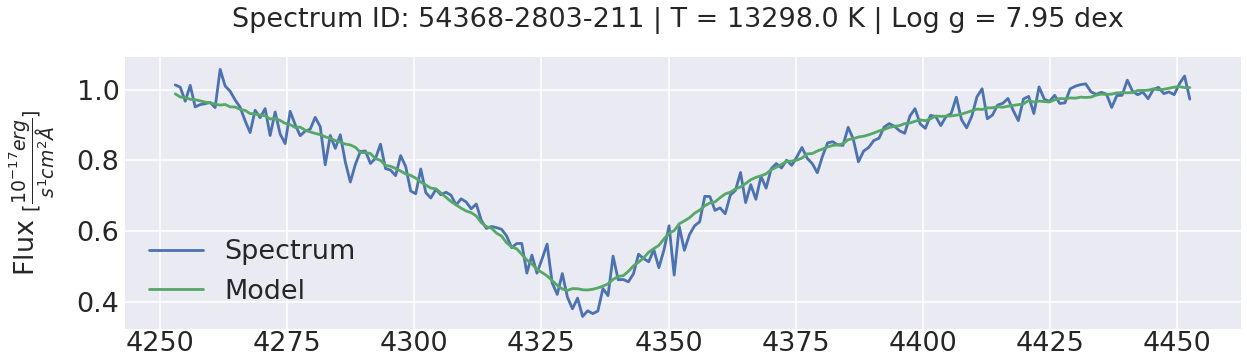

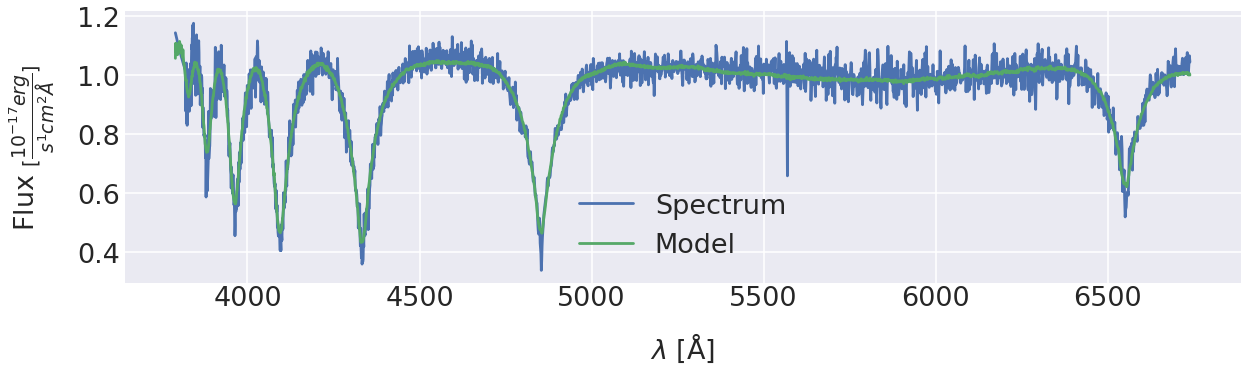

In [129]:
plot_train_model(5)

_Plot 11: Only intermediate temperature spectra is used. 11.a shows a zoomed version of the model-spectra comparison in a model fit across the entire range of effective temperature. 11.b shows a broader version of the same spectra, that illustrates how the model tends to follow the general outlines of the spectra across all avilable wavelengths._

In [130]:
rms_T, bias_T, scatter_T = error(Apstar[:,0], Estimator[:,0], 'T_eff ', ' [K]')
rms_G, bias_G, scatter_G = error(Apstar[:,1], Estimator[:,1], 'Logg G', " [dex]")



RMS         T_eff  :    2547.003  [K]
Bias        T_eff  :    -1029.13  [K]
Scatter     T_eff  :    2326.434  [K]
------------------------------------


RMS         Logg G :    0.201  [dex]
Bias        Logg G :    0.02  [dex]
Scatter     Logg G :    0.2  [dex]
------------------------------------


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


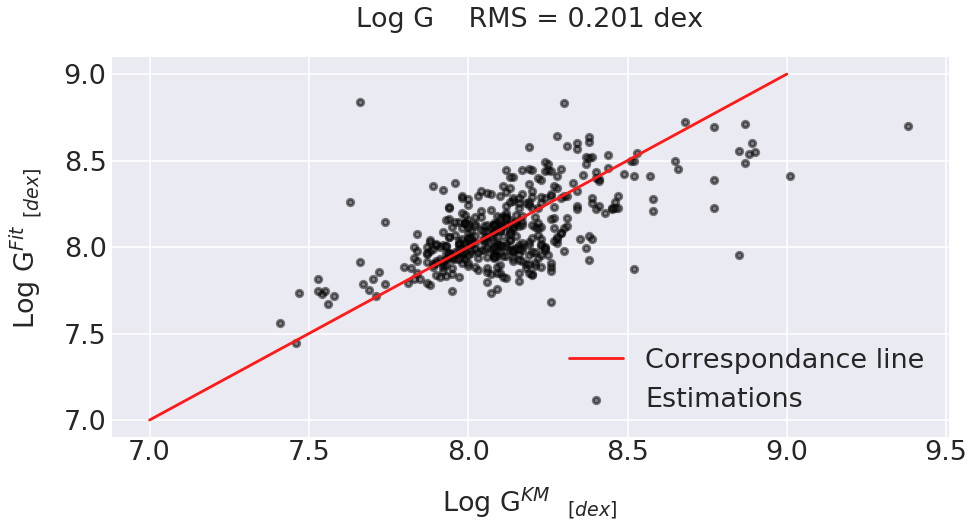

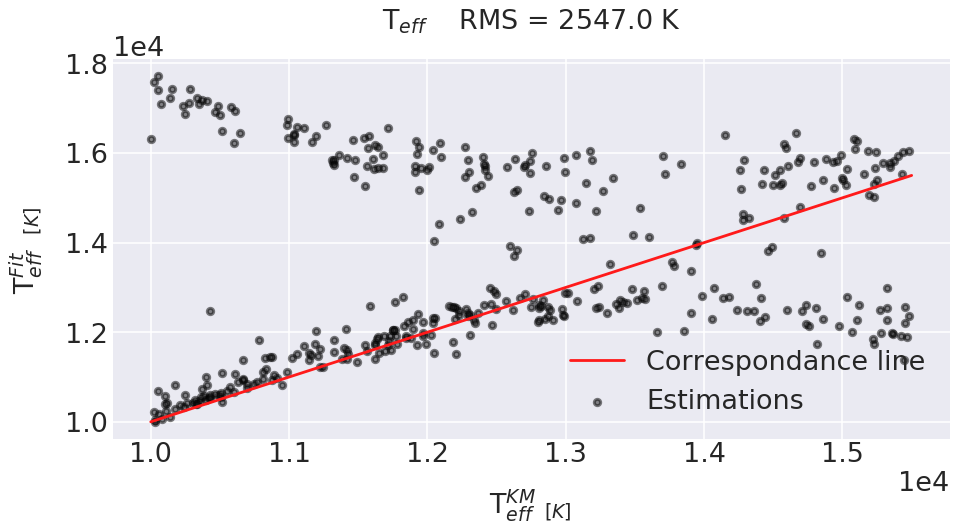

In [131]:
plot_compar2([7,9],[7,9], [10e3,15.5e3],[10e3,15.5e3])

_Plot 12: Only intermediate temperature spectra are used. Plot 12.a shows the correspondence between the models estimated values for the surface gravitation and the Kleinman Log g. Plot 12.b shows the correspondence between the models estimated values for the effective temperature and the Kleinman effective temperature._

### 2.2.b Evaluation of model - Intermediate temperatures

Looking at plot 9 there is no immediately evident deviation from previous results, but looking at plot 10 it becomes clear that something went wrong. The bifurcation is again evident. Interestingly enough the correspondence in log g actually improved slightly. 


### 2.3.a Application in the Low T region

Next we apply the model to the region  T < 10000 K.

In [132]:
data_low_T = data_[(data_['Teff'] < 10000)]
cn_spec  =  np.vstack(data_low_T['cn_spec'])             
cn_spec_err = np.vstack(data_low_T['cn_spec_err'] )
spectra = np.vstack(data_low_T['spectra'])

labels, ASPCAP_labels_ERR, scaler, ASPCAP_labels = expand_labelset(data_low_T)
ID_train, ID_test, labels_train, labels_test, labels_err_train, labels_err_test ,err_train, err_test, y_train, y_test, labels_unscaled_train,labels_unscaled_test = train_test_split(data_low_T['key'], labels, ASPCAP_labels_ERR, cn_spec_err,  cn_spec, ASPCAP_labels, test_size=0.5, random_state=42)
N_test, N_labels, N_pixels = len(y_test), 6, len(y_test[0])

theta = build_model(y_train, labels_train, err_train)

model_trained_data = np.matmul(theta.T, labels_train.T).T



model_of_test = model()

Estimator = scaler.inverse_transform(model_of_test)
Apstar = scaler.inverse_transform(labels_test[:,1:3])

100%|██████████| 411/411 [00:03<00:00, 121.74it/s]


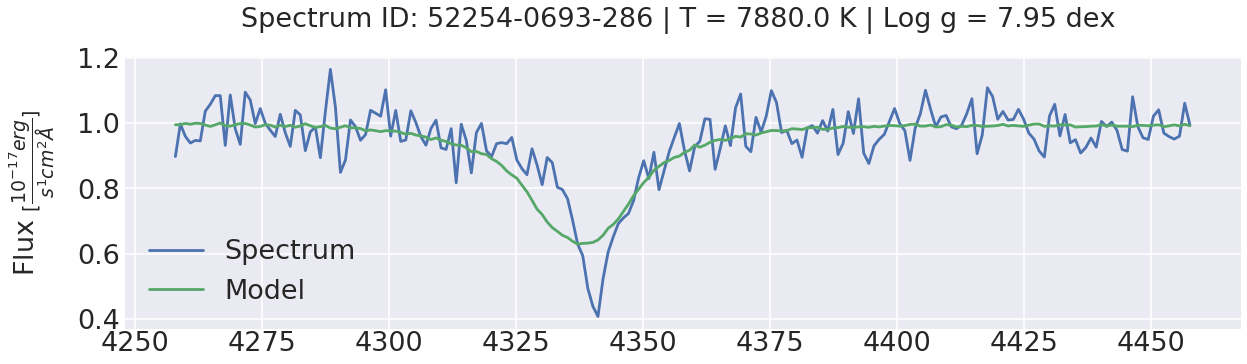

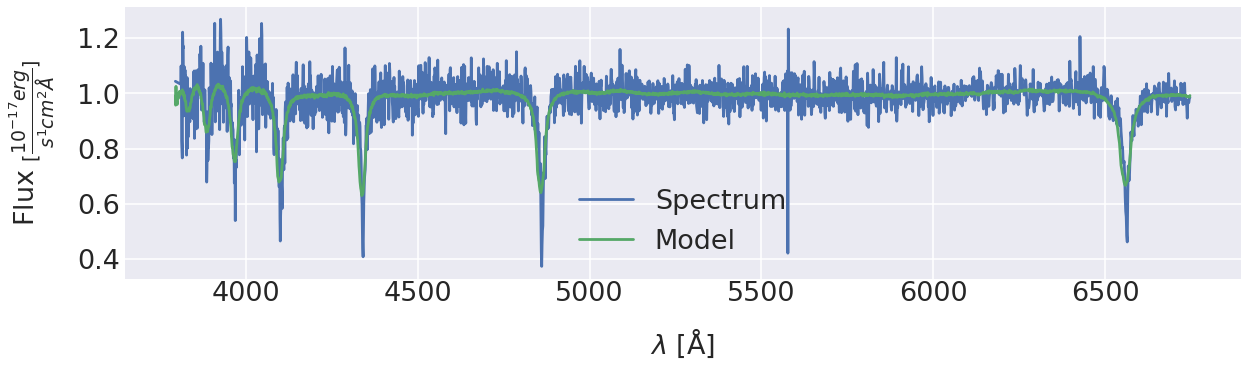

In [133]:
plot_train_model(115)

_Plot 13: Only low temperature spectra is used. 13.a shows a zoomed version of the model-spectra comparison in a model fit across the entire range of effective temperature. 13.b shows a broader version of the same spectra, that illustrates how the model tends to follow the general outlines of the spectra across all avilable wavelengths._

In [134]:
rms_T, bias_T, scatter_T = error(Apstar[:,0], Estimator[:,0], 'T_eff ', ' [K]')
rms_G, bias_G, scatter_G = error(Apstar[:,1], Estimator[:,1], 'Logg G', " [dex]")



RMS         T_eff  :    194.712  [K]
Bias        T_eff  :    9.041  [K]
Scatter     T_eff  :    194.266  [K]
------------------------------------


RMS         Logg G :    0.377  [dex]
Bias        Logg G :    -0.061  [dex]
Scatter     Logg G :    0.371  [dex]
------------------------------------


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


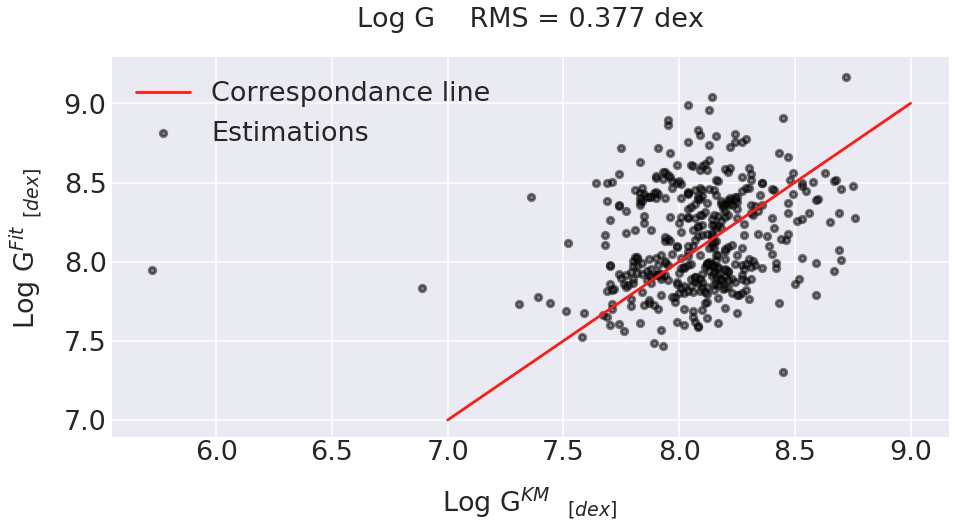

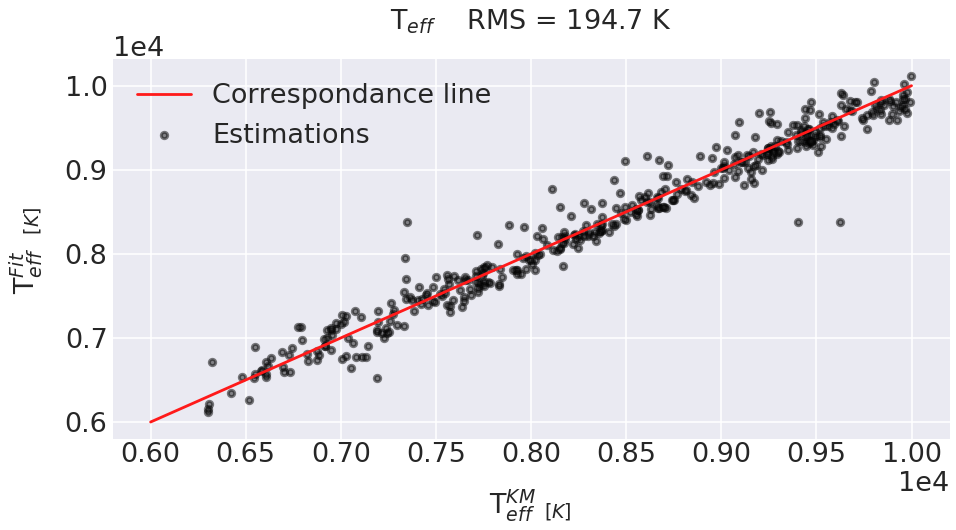

In [135]:
plot_compar2([7,9],[7,9], [6e3,10e3],[6e3,10e3])

_Plot 14: Only low temperature spectra are used. Plot 14.a shows the correspondence between the models estimated values for the surface gravitation and the Kleinman Log g. Plot 14.b shows the correspondence between the models estimated values for the effective temperature and the Kleinman effective temperature._

### 2.3.b Evaluation of model - Low temperatures

In plot 13 it appears that the model is not as good as in the other two regimes. Looking at plot 14 on the other hand reveals that the model is actually not to bad at estimating the effective temperature. The log g fit on the other hand has seen a significant increase in the RMS value, approaching what it would look if one just were to guess at random. 
 
### 2.4 Discussion of model application 

What we found in the analysis above is that the models performance vastly varies in regards to the data it is applied to. It initially appears to be highly dependable on distinguishable and characteristic pseudo-normalized spectra. It makes sense that it would fit well in the regions where the balmer lines are evident, and the absorption lines well defines, as in the high temperature regime. When adjusting the upper limit for this regime to include all spectra with temperatures above 15.500 K the model preforms worse than with an upper limit of 40.000 K. This is probably due to the fact that very hot white dwarfs have quite featureless spectra, which the model has a hard time interpreting. When the spectra become more indistinguishable in the low temperature regime, it reflects onto the models performance. This is particularly evident in the RMS of log G, where the range of values does not alternate in size on the same scale as for the effective temperature. A more extensive analysis is needed in order to better understand the nuances of these variations. 



## 3. Probing for additional information using a neural net

As an additional supplement in the very end, an attempt is made to probe for more information about the normalization using a neural net across the entire temperature range. 

In [136]:
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras

from keras.models import Sequential
from keras import optimizers
from keras.layers import Dense, Activation

print(tf.__version__)


data_T = data_[data_['Teff'] > 1]
cn_spec  =  np.vstack(data_T['cn_spec'])             
cn_spec_err = np.vstack(data_T['cn_spec_err'] )

labels, ASPCAP_labels_ERR, scaler, ASPCAP_labels = expand_labelset(data_)
ID_train, ID_test, labels_train, labels_test, labels_err_train, labels_err_test ,err_train, err_test, y_train, y_test, labels_unscaled_train,labels_unscaled_test = train_test_split(data_['key'], labels, ASPCAP_labels_ERR, cn_spec_err,  cn_spec, ASPCAP_labels, test_size=0.5, random_state=42)
N_test, N_labels, N_pixels = len(y_test), 6, len(y_test[0])

1.13.1


In [137]:
y_train_chip = np.array(y_train)
y_test_chip = y_test

X_train_scaled = y_train_chip
X_test_scaled = y_test_chip


y_train_labels = labels_train[:,1:3]
y_test_labels  = labels_test[:,1:3]



In [138]:
opti = optimizers.adam(amsgrad=True, lr=0.0003)
def nn_clf():
    model = Sequential()
    model.add(Dense(30, input_shape=(2500,), activation="linear", kernel_initializer='random_uniform'))
    model.add(Dense(30,  activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(30,  activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(2, activation="linear", kernel_initializer='random_uniform'))
    model.compile(optimizer=opti, loss='mean_squared_error',  metrics=['mae',"mse"])
    return model

In [ ]:
nn_clf().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 30)                75030     
_________________________________________________________________
dense_10 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_11 (Dense)             (None, 30)                930       
_________________________________________________________________
dense_12 (Dense)             (None, 2)                 62        
Total params: 76,952
Trainable params: 76,952
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score, KFold

clf = KerasRegressor(build_fn=nn_clf, batch_size=36, epochs=2000)
clf.fit(X_train_scaled, y_train_labels)

Epoch 1/2000
1626/1626 [==============================] - 0s 184us/step - loss: 0.9731 - mean_absolute_error: 0.7513 - mean_squared_error: 0.9731
Epoch 2/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.9730 - mean_absolute_error: 0.7504 - mean_squared_error: 0.9730
Epoch 3/2000
1626/1626 [==============================] - 0s 45us/step - loss: 0.9729 - mean_absolute_error: 0.7511 - mean_squared_error: 0.9729
Epoch 4/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.9728 - mean_absolute_error: 0.7504 - mean_squared_error: 0.9728
Epoch 5/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.9731 - mean_absolute_error: 0.7489 - mean_squared_error: 0.9731
Epoch 6/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.9728 - mean_absolute_error: 0.7503 - mean_squared_error: 0.9728
Epoch 7/2000
1626/1626 [==============================] - 0s 48us/step - loss: 0.9732 - mean_absolute_error: 0.7510 - mean_square

1626/1626 [==============================] - 0s 48us/step - loss: 0.6151 - mean_absolute_error: 0.5626 - mean_squared_error: 0.6151
Epoch 58/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.6194 - mean_absolute_error: 0.5682 - mean_squared_error: 0.6194
Epoch 59/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.6418 - mean_absolute_error: 0.5791 - mean_squared_error: 0.6418
Epoch 60/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.6428 - mean_absolute_error: 0.5844 - mean_squared_error: 0.6428
Epoch 61/2000
1626/1626 [==============================] - 0s 48us/step - loss: 0.6074 - mean_absolute_error: 0.5627 - mean_squared_error: 0.6074
Epoch 62/2000
1626/1626 [==============================] - 0s 48us/step - loss: 0.6119 - mean_absolute_error: 0.5650 - mean_squared_error: 0.6119
Epoch 63/2000
1626/1626 [==============================] - 0s 48us/step - loss: 0.5872 - mean_absolute_error: 0.5526 - mean_squared_error:

1626/1626 [==============================] - 0s 48us/step - loss: 0.3766 - mean_absolute_error: 0.4271 - mean_squared_error: 0.3766
Epoch 114/2000
1626/1626 [==============================] - 0s 48us/step - loss: 0.4189 - mean_absolute_error: 0.4498 - mean_squared_error: 0.4189
Epoch 115/2000
1626/1626 [==============================] - 0s 49us/step - loss: 0.3912 - mean_absolute_error: 0.4379 - mean_squared_error: 0.3912
Epoch 116/2000
1626/1626 [==============================] - 0s 48us/step - loss: 0.3442 - mean_absolute_error: 0.4022 - mean_squared_error: 0.3442
Epoch 117/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.3620 - mean_absolute_error: 0.4171 - mean_squared_error: 0.3620
Epoch 118/2000
1626/1626 [==============================] - 0s 49us/step - loss: 0.3443 - mean_absolute_error: 0.4019 - mean_squared_error: 0.3443
Epoch 119/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.3361 - mean_absolute_error: 0.3998 - mean_squared_

1626/1626 [==============================] - 0s 47us/step - loss: 0.2502 - mean_absolute_error: 0.3339 - mean_squared_error: 0.2502
Epoch 169/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.2254 - mean_absolute_error: 0.3165 - mean_squared_error: 0.2254
Epoch 170/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.2337 - mean_absolute_error: 0.3192 - mean_squared_error: 0.2337
Epoch 171/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.2193 - mean_absolute_error: 0.3080 - mean_squared_error: 0.2193
Epoch 172/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.2466 - mean_absolute_error: 0.3344 - mean_squared_error: 0.2466
Epoch 173/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.2460 - mean_absolute_error: 0.3319 - mean_squared_error: 0.2460
Epoch 174/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.2454 - mean_absolute_error: 0.3328 - mean_squared_

1626/1626 [==============================] - 0s 47us/step - loss: 0.1796 - mean_absolute_error: 0.2758 - mean_squared_error: 0.1796
Epoch 224/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.1995 - mean_absolute_error: 0.2951 - mean_squared_error: 0.1995
Epoch 225/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.1741 - mean_absolute_error: 0.2721 - mean_squared_error: 0.1741
Epoch 226/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.1749 - mean_absolute_error: 0.2726 - mean_squared_error: 0.1749
Epoch 227/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.1949 - mean_absolute_error: 0.2872 - mean_squared_error: 0.1949
Epoch 228/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.1646 - mean_absolute_error: 0.2611 - mean_squared_error: 0.1646
Epoch 229/2000
1626/1626 [==============================] - 0s 45us/step - loss: 0.1824 - mean_absolute_error: 0.2776 - mean_squared_

1626/1626 [==============================] - 0s 45us/step - loss: 0.1396 - mean_absolute_error: 0.2380 - mean_squared_error: 0.1396
Epoch 279/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.1489 - mean_absolute_error: 0.2493 - mean_squared_error: 0.1489
Epoch 280/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.1443 - mean_absolute_error: 0.2424 - mean_squared_error: 0.1443
Epoch 281/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.1599 - mean_absolute_error: 0.2582 - mean_squared_error: 0.1599
Epoch 282/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.1610 - mean_absolute_error: 0.2594 - mean_squared_error: 0.1610
Epoch 283/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.1485 - mean_absolute_error: 0.2433 - mean_squared_error: 0.1485
Epoch 284/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.1499 - mean_absolute_error: 0.2484 - mean_squared_

1626/1626 [==============================] - 0s 47us/step - loss: 0.1233 - mean_absolute_error: 0.2227 - mean_squared_error: 0.1233
Epoch 334/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.1200 - mean_absolute_error: 0.2216 - mean_squared_error: 0.1200
Epoch 335/2000
1626/1626 [==============================] - 0s 45us/step - loss: 0.1239 - mean_absolute_error: 0.2254 - mean_squared_error: 0.1239
Epoch 336/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.2358 - mean_absolute_error: 0.3136 - mean_squared_error: 0.2358
Epoch 337/2000
1626/1626 [==============================] - 0s 48us/step - loss: 0.1174 - mean_absolute_error: 0.2156 - mean_squared_error: 0.1174
Epoch 338/2000
1626/1626 [==============================] - 0s 49us/step - loss: 0.1528 - mean_absolute_error: 0.2523 - mean_squared_error: 0.1528
Epoch 339/2000
1626/1626 [==============================] - 0s 49us/step - loss: 0.1146 - mean_absolute_error: 0.2103 - mean_squared_

1626/1626 [==============================] - 0s 49us/step - loss: 0.1225 - mean_absolute_error: 0.2242 - mean_squared_error: 0.1225
Epoch 389/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.1079 - mean_absolute_error: 0.2067 - mean_squared_error: 0.1079
Epoch 390/2000
1626/1626 [==============================] - 0s 48us/step - loss: 0.1006 - mean_absolute_error: 0.1977 - mean_squared_error: 0.1006
Epoch 391/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0972 - mean_absolute_error: 0.1911 - mean_squared_error: 0.0972
Epoch 392/2000
1626/1626 [==============================] - 0s 45us/step - loss: 0.1029 - mean_absolute_error: 0.2026 - mean_squared_error: 0.1029
Epoch 393/2000
1626/1626 [==============================] - 0s 44us/step - loss: 0.1074 - mean_absolute_error: 0.2070 - mean_squared_error: 0.1074
Epoch 394/2000
1626/1626 [==============================] - 0s 44us/step - loss: 0.0958 - mean_absolute_error: 0.1916 - mean_squared_

1626/1626 [==============================] - 0s 49us/step - loss: 0.0949 - mean_absolute_error: 0.1919 - mean_squared_error: 0.0949
Epoch 444/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0930 - mean_absolute_error: 0.1895 - mean_squared_error: 0.0930
Epoch 445/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0898 - mean_absolute_error: 0.1859 - mean_squared_error: 0.0898
Epoch 446/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0898 - mean_absolute_error: 0.1835 - mean_squared_error: 0.0898
Epoch 447/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0882 - mean_absolute_error: 0.1847 - mean_squared_error: 0.0882
Epoch 448/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0879 - mean_absolute_error: 0.1830 - mean_squared_error: 0.0879
Epoch 449/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0866 - mean_absolute_error: 0.1836 - mean_squared_

1626/1626 [==============================] - 0s 47us/step - loss: 0.1038 - mean_absolute_error: 0.2114 - mean_squared_error: 0.1038
Epoch 499/2000
1626/1626 [==============================] - 0s 45us/step - loss: 0.0800 - mean_absolute_error: 0.1718 - mean_squared_error: 0.0800
Epoch 500/2000
1626/1626 [==============================] - 0s 44us/step - loss: 0.0965 - mean_absolute_error: 0.1970 - mean_squared_error: 0.0965
Epoch 501/2000
1626/1626 [==============================] - 0s 44us/step - loss: 0.0794 - mean_absolute_error: 0.1723 - mean_squared_error: 0.0794
Epoch 502/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.1074 - mean_absolute_error: 0.2140 - mean_squared_error: 0.1074
Epoch 503/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0901 - mean_absolute_error: 0.1884 - mean_squared_error: 0.0901
Epoch 504/2000
1626/1626 [==============================] - 0s 45us/step - loss: 0.0737 - mean_absolute_error: 0.1680 - mean_squared_

1626/1626 [==============================] - 0s 45us/step - loss: 0.0792 - mean_absolute_error: 0.1737 - mean_squared_error: 0.0792
Epoch 554/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0712 - mean_absolute_error: 0.1618 - mean_squared_error: 0.0712
Epoch 555/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0817 - mean_absolute_error: 0.1794 - mean_squared_error: 0.0817
Epoch 556/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0732 - mean_absolute_error: 0.1730 - mean_squared_error: 0.0732
Epoch 557/2000
1626/1626 [==============================] - 0s 45us/step - loss: 0.0732 - mean_absolute_error: 0.1680 - mean_squared_error: 0.0732
Epoch 558/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0822 - mean_absolute_error: 0.1810 - mean_squared_error: 0.0822
Epoch 559/2000
1626/1626 [==============================] - 0s 45us/step - loss: 0.0757 - mean_absolute_error: 0.1712 - mean_squared_

1626/1626 [==============================] - 0s 46us/step - loss: 0.0715 - mean_absolute_error: 0.1648 - mean_squared_error: 0.0715
Epoch 609/2000
1626/1626 [==============================] - 0s 45us/step - loss: 0.0653 - mean_absolute_error: 0.1573 - mean_squared_error: 0.0653
Epoch 610/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0738 - mean_absolute_error: 0.1689 - mean_squared_error: 0.0738
Epoch 611/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0721 - mean_absolute_error: 0.1709 - mean_squared_error: 0.0721
Epoch 612/2000
1626/1626 [==============================] - 0s 45us/step - loss: 0.0707 - mean_absolute_error: 0.1665 - mean_squared_error: 0.0707
Epoch 613/2000
1626/1626 [==============================] - 0s 45us/step - loss: 0.0687 - mean_absolute_error: 0.1652 - mean_squared_error: 0.0687
Epoch 614/2000
1626/1626 [==============================] - 0s 48us/step - loss: 0.0629 - mean_absolute_error: 0.1529 - mean_squared_

1626/1626 [==============================] - 0s 47us/step - loss: 0.0649 - mean_absolute_error: 0.1593 - mean_squared_error: 0.0649
Epoch 664/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0628 - mean_absolute_error: 0.1540 - mean_squared_error: 0.0628
Epoch 665/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0630 - mean_absolute_error: 0.1539 - mean_squared_error: 0.0630
Epoch 666/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0647 - mean_absolute_error: 0.1588 - mean_squared_error: 0.0647
Epoch 667/2000
1626/1626 [==============================] - 0s 48us/step - loss: 0.0614 - mean_absolute_error: 0.1509 - mean_squared_error: 0.0614
Epoch 668/2000
1626/1626 [==============================] - 0s 48us/step - loss: 0.0600 - mean_absolute_error: 0.1500 - mean_squared_error: 0.0600
Epoch 669/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0630 - mean_absolute_error: 0.1546 - mean_squared_

1626/1626 [==============================] - 0s 48us/step - loss: 0.0568 - mean_absolute_error: 0.1469 - mean_squared_error: 0.0568
Epoch 719/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0554 - mean_absolute_error: 0.1416 - mean_squared_error: 0.0554
Epoch 720/2000
1626/1626 [==============================] - 0s 49us/step - loss: 0.0539 - mean_absolute_error: 0.1435 - mean_squared_error: 0.0539
Epoch 721/2000
1626/1626 [==============================] - 0s 48us/step - loss: 0.0552 - mean_absolute_error: 0.1466 - mean_squared_error: 0.0552
Epoch 722/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0632 - mean_absolute_error: 0.1595 - mean_squared_error: 0.0632
Epoch 723/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0586 - mean_absolute_error: 0.1483 - mean_squared_error: 0.0586
Epoch 724/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0620 - mean_absolute_error: 0.1551 - mean_squared_

1626/1626 [==============================] - 0s 49us/step - loss: 0.0571 - mean_absolute_error: 0.1470 - mean_squared_error: 0.0571
Epoch 774/2000
1626/1626 [==============================] - 0s 48us/step - loss: 0.0580 - mean_absolute_error: 0.1467 - mean_squared_error: 0.0580
Epoch 775/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0514 - mean_absolute_error: 0.1359 - mean_squared_error: 0.0514
Epoch 776/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0517 - mean_absolute_error: 0.1384 - mean_squared_error: 0.0517
Epoch 777/2000
1626/1626 [==============================] - 0s 45us/step - loss: 0.0608 - mean_absolute_error: 0.1542 - mean_squared_error: 0.0608
Epoch 778/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0640 - mean_absolute_error: 0.1617 - mean_squared_error: 0.0640
Epoch 779/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0526 - mean_absolute_error: 0.1370 - mean_squared_

1626/1626 [==============================] - 0s 46us/step - loss: 0.0498 - mean_absolute_error: 0.1377 - mean_squared_error: 0.0498
Epoch 829/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0537 - mean_absolute_error: 0.1412 - mean_squared_error: 0.0537
Epoch 830/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0638 - mean_absolute_error: 0.1593 - mean_squared_error: 0.0638
Epoch 831/2000
1626/1626 [==============================] - 0s 45us/step - loss: 0.0531 - mean_absolute_error: 0.1398 - mean_squared_error: 0.0531
Epoch 832/2000
1626/1626 [==============================] - 0s 44us/step - loss: 0.0499 - mean_absolute_error: 0.1364 - mean_squared_error: 0.0499
Epoch 833/2000
1626/1626 [==============================] - 0s 45us/step - loss: 0.0686 - mean_absolute_error: 0.1687 - mean_squared_error: 0.0686
Epoch 834/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0562 - mean_absolute_error: 0.1474 - mean_squared_

1626/1626 [==============================] - 0s 46us/step - loss: 0.0454 - mean_absolute_error: 0.1286 - mean_squared_error: 0.0454
Epoch 884/2000
1626/1626 [==============================] - 0s 49us/step - loss: 0.0570 - mean_absolute_error: 0.1517 - mean_squared_error: 0.0570
Epoch 885/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0442 - mean_absolute_error: 0.1269 - mean_squared_error: 0.0442
Epoch 886/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0636 - mean_absolute_error: 0.1618 - mean_squared_error: 0.0636
Epoch 887/2000
1626/1626 [==============================] - 0s 48us/step - loss: 0.0670 - mean_absolute_error: 0.1638 - mean_squared_error: 0.0670
Epoch 888/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0434 - mean_absolute_error: 0.1262 - mean_squared_error: 0.0434
Epoch 889/2000
1626/1626 [==============================] - 0s 49us/step - loss: 0.0489 - mean_absolute_error: 0.1388 - mean_squared_

1626/1626 [==============================] - 0s 46us/step - loss: 0.0424 - mean_absolute_error: 0.1270 - mean_squared_error: 0.0424
Epoch 939/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0461 - mean_absolute_error: 0.1319 - mean_squared_error: 0.0461
Epoch 940/2000
1626/1626 [==============================] - 0s 48us/step - loss: 0.0413 - mean_absolute_error: 0.1240 - mean_squared_error: 0.0413
Epoch 941/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0518 - mean_absolute_error: 0.1435 - mean_squared_error: 0.0518
Epoch 942/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0435 - mean_absolute_error: 0.1276 - mean_squared_error: 0.0435
Epoch 943/2000
1626/1626 [==============================] - 0s 48us/step - loss: 0.0459 - mean_absolute_error: 0.1326 - mean_squared_error: 0.0459
Epoch 944/2000
1626/1626 [==============================] - 0s 48us/step - loss: 0.0447 - mean_absolute_error: 0.1311 - mean_squared_

1626/1626 [==============================] - 0s 47us/step - loss: 0.0413 - mean_absolute_error: 0.1220 - mean_squared_error: 0.0413
Epoch 994/2000
1626/1626 [==============================] - 0s 48us/step - loss: 0.0499 - mean_absolute_error: 0.1401 - mean_squared_error: 0.0499
Epoch 995/2000
1626/1626 [==============================] - 0s 49us/step - loss: 0.0427 - mean_absolute_error: 0.1314 - mean_squared_error: 0.0427
Epoch 996/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0421 - mean_absolute_error: 0.1255 - mean_squared_error: 0.0421
Epoch 997/2000
1626/1626 [==============================] - 0s 45us/step - loss: 0.0464 - mean_absolute_error: 0.1323 - mean_squared_error: 0.0464
Epoch 998/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0503 - mean_absolute_error: 0.1420 - mean_squared_error: 0.0503
Epoch 999/2000
1626/1626 [==============================] - 0s 45us/step - loss: 0.0494 - mean_absolute_error: 0.1417 - mean_squared_

1626/1626 [==============================] - 0s 49us/step - loss: 0.0403 - mean_absolute_error: 0.1210 - mean_squared_error: 0.0403
Epoch 1049/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0404 - mean_absolute_error: 0.1238 - mean_squared_error: 0.0404
Epoch 1050/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0405 - mean_absolute_error: 0.1269 - mean_squared_error: 0.0405
Epoch 1051/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0370 - mean_absolute_error: 0.1174 - mean_squared_error: 0.0370
Epoch 1052/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0431 - mean_absolute_error: 0.1257 - mean_squared_error: 0.0431
Epoch 1053/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0356 - mean_absolute_error: 0.1152 - mean_squared_error: 0.0356
Epoch 1054/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0450 - mean_absolute_error: 0.1313 - mean_sq

1626/1626 [==============================] - 0s 47us/step - loss: 0.0321 - mean_absolute_error: 0.1076 - mean_squared_error: 0.0321
Epoch 1104/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0424 - mean_absolute_error: 0.1284 - mean_squared_error: 0.0424
Epoch 1105/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0329 - mean_absolute_error: 0.1103 - mean_squared_error: 0.0329
Epoch 1106/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0387 - mean_absolute_error: 0.1249 - mean_squared_error: 0.0387
Epoch 1107/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0431 - mean_absolute_error: 0.1319 - mean_squared_error: 0.0431
Epoch 1108/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0332 - mean_absolute_error: 0.1109 - mean_squared_error: 0.0332
Epoch 1109/2000
1626/1626 [==============================] - 0s 45us/step - loss: 0.0402 - mean_absolute_error: 0.1254 - mean_sq

1626/1626 [==============================] - 0s 46us/step - loss: 0.0313 - mean_absolute_error: 0.1078 - mean_squared_error: 0.0313
Epoch 1159/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0313 - mean_absolute_error: 0.1082 - mean_squared_error: 0.0313
Epoch 1160/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0414 - mean_absolute_error: 0.1274 - mean_squared_error: 0.0414
Epoch 1161/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.0378 - mean_absolute_error: 0.1239 - mean_squared_error: 0.0378
Epoch 1162/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0345 - mean_absolute_error: 0.1124 - mean_squared_error: 0.0345
Epoch 1163/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0461 - mean_absolute_error: 0.1371 - mean_squared_error: 0.0461
Epoch 1164/2000
1626/1626 [==============================] - 0s 48us/step - loss: 0.0323 - mean_absolute_error: 0.1098 - mean_sq

1626/1626 [==============================] - 0s 46us/step - loss: 0.0347 - mean_absolute_error: 0.1163 - mean_squared_error: 0.0347
Epoch 1214/2000
1626/1626 [==============================] - 0s 46us/step - loss: 0.1066 - mean_absolute_error: 0.1985 - mean_squared_error: 0.1066
Epoch 1215/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0550 - mean_absolute_error: 0.1564 - mean_squared_error: 0.0550
Epoch 1216/2000
1626/1626 [==============================] - 0s 49us/step - loss: 0.0309 - mean_absolute_error: 0.1083 - mean_squared_error: 0.0309
Epoch 1217/2000
1626/1626 [==============================] - 0s 48us/step - loss: 0.0308 - mean_absolute_error: 0.1071 - mean_squared_error: 0.0308
Epoch 1218/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0300 - mean_absolute_error: 0.1062 - mean_squared_error: 0.0300
Epoch 1219/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0280 - mean_absolute_error: 0.1019 - mean_sq

1626/1626 [==============================] - 0s 52us/step - loss: 0.0314 - mean_absolute_error: 0.1092 - mean_squared_error: 0.0314
Epoch 1269/2000
1626/1626 [==============================] - 0s 54us/step - loss: 0.0295 - mean_absolute_error: 0.1052 - mean_squared_error: 0.0295
Epoch 1270/2000
1626/1626 [==============================] - 0s 52us/step - loss: 0.0297 - mean_absolute_error: 0.1043 - mean_squared_error: 0.0297
Epoch 1271/2000
1626/1626 [==============================] - 0s 55us/step - loss: 0.0412 - mean_absolute_error: 0.1281 - mean_squared_error: 0.0412
Epoch 1272/2000
1626/1626 [==============================] - 0s 54us/step - loss: 0.0296 - mean_absolute_error: 0.1053 - mean_squared_error: 0.0296
Epoch 1273/2000
1626/1626 [==============================] - 0s 59us/step - loss: 0.0313 - mean_absolute_error: 0.1094 - mean_squared_error: 0.0313
Epoch 1274/2000
1626/1626 [==============================] - 0s 59us/step - loss: 0.0293 - mean_absolute_error: 0.1054 - mean_sq

1626/1626 [==============================] - 0s 57us/step - loss: 0.0320 - mean_absolute_error: 0.1107 - mean_squared_error: 0.0320
Epoch 1324/2000
1626/1626 [==============================] - 0s 57us/step - loss: 0.0339 - mean_absolute_error: 0.1160 - mean_squared_error: 0.0339
Epoch 1325/2000
1626/1626 [==============================] - 0s 53us/step - loss: 0.0307 - mean_absolute_error: 0.1071 - mean_squared_error: 0.0307
Epoch 1326/2000
1626/1626 [==============================] - 0s 54us/step - loss: 0.0292 - mean_absolute_error: 0.1049 - mean_squared_error: 0.0292
Epoch 1327/2000
1626/1626 [==============================] - 0s 52us/step - loss: 0.0339 - mean_absolute_error: 0.1134 - mean_squared_error: 0.0339
Epoch 1328/2000
1626/1626 [==============================] - 0s 52us/step - loss: 0.0437 - mean_absolute_error: 0.1282 - mean_squared_error: 0.0437
Epoch 1329/2000
1626/1626 [==============================] - 0s 52us/step - loss: 0.0259 - mean_absolute_error: 0.0975 - mean_sq

1626/1626 [==============================] - 0s 53us/step - loss: 0.0270 - mean_absolute_error: 0.1024 - mean_squared_error: 0.0270
Epoch 1379/2000
1626/1626 [==============================] - 0s 54us/step - loss: 0.0381 - mean_absolute_error: 0.1251 - mean_squared_error: 0.0381
Epoch 1380/2000
1626/1626 [==============================] - 0s 55us/step - loss: 0.0280 - mean_absolute_error: 0.1033 - mean_squared_error: 0.0280
Epoch 1381/2000
1626/1626 [==============================] - 0s 56us/step - loss: 0.0246 - mean_absolute_error: 0.0941 - mean_squared_error: 0.0246
Epoch 1382/2000
1626/1626 [==============================] - 0s 53us/step - loss: 0.0244 - mean_absolute_error: 0.0934 - mean_squared_error: 0.0244
Epoch 1383/2000
1626/1626 [==============================] - 0s 53us/step - loss: 0.0251 - mean_absolute_error: 0.0959 - mean_squared_error: 0.0251
Epoch 1384/2000
1626/1626 [==============================] - 0s 55us/step - loss: 0.0284 - mean_absolute_error: 0.1038 - mean_sq

1626/1626 [==============================] - 0s 47us/step - loss: 0.0252 - mean_absolute_error: 0.0964 - mean_squared_error: 0.0252
Epoch 1434/2000
1626/1626 [==============================] - 0s 47us/step - loss: 0.0232 - mean_absolute_error: 0.0914 - mean_squared_error: 0.0232
Epoch 1435/2000
1626/1626 [==============================] - 0s 49us/step - loss: 0.0280 - mean_absolute_error: 0.1038 - mean_squared_error: 0.0280
Epoch 1436/2000
1626/1626 [==============================] - 0s 62us/step - loss: 0.0247 - mean_absolute_error: 0.0956 - mean_squared_error: 0.0247
Epoch 1437/2000
1626/1626 [==============================] - 0s 59us/step - loss: 0.0283 - mean_absolute_error: 0.1012 - mean_squared_error: 0.0283
Epoch 1438/2000
1626/1626 [==============================] - 0s 57us/step - loss: 0.0275 - mean_absolute_error: 0.1031 - mean_squared_error: 0.0275
Epoch 1439/2000
1626/1626 [==============================] - 0s 55us/step - loss: 0.0336 - mean_absolute_error: 0.1166 - mean_sq

1626/1626 [==============================] - 0s 53us/step - loss: 0.0224 - mean_absolute_error: 0.0901 - mean_squared_error: 0.0224
Epoch 1489/2000
1626/1626 [==============================] - 0s 58us/step - loss: 0.0246 - mean_absolute_error: 0.0972 - mean_squared_error: 0.0246
Epoch 1490/2000
1626/1626 [==============================] - 0s 55us/step - loss: 0.0267 - mean_absolute_error: 0.1002 - mean_squared_error: 0.0267
Epoch 1491/2000
1626/1626 [==============================] - 0s 55us/step - loss: 0.0257 - mean_absolute_error: 0.0969 - mean_squared_error: 0.0257
Epoch 1492/2000
1626/1626 [==============================] - 0s 55us/step - loss: 0.0251 - mean_absolute_error: 0.0967 - mean_squared_error: 0.0251
Epoch 1493/2000
1626/1626 [==============================] - 0s 56us/step - loss: 0.0232 - mean_absolute_error: 0.0941 - mean_squared_error: 0.0232
Epoch 1494/2000
1626/1626 [==============================] - 0s 53us/step - loss: 0.0241 - mean_absolute_error: 0.0960 - mean_sq

1626/1626 [==============================] - 0s 53us/step - loss: 0.0223 - mean_absolute_error: 0.0903 - mean_squared_error: 0.0223
Epoch 1544/2000
1626/1626 [==============================] - 0s 55us/step - loss: 0.0224 - mean_absolute_error: 0.0916 - mean_squared_error: 0.0224
Epoch 1545/2000
1626/1626 [==============================] - 0s 54us/step - loss: 0.0235 - mean_absolute_error: 0.0928 - mean_squared_error: 0.0235
Epoch 1546/2000
1626/1626 [==============================] - 0s 55us/step - loss: 0.0241 - mean_absolute_error: 0.0985 - mean_squared_error: 0.0241
Epoch 1547/2000
1626/1626 [==============================] - 0s 56us/step - loss: 0.0208 - mean_absolute_error: 0.0871 - mean_squared_error: 0.0208
Epoch 1548/2000
1626/1626 [==============================] - 0s 57us/step - loss: 0.0257 - mean_absolute_error: 0.1007 - mean_squared_error: 0.0257
Epoch 1549/2000
1626/1626 [==============================] - 0s 57us/step - loss: 0.0264 - mean_absolute_error: 0.0999 - mean_sq

1626/1626 [==============================] - 0s 57us/step - loss: 0.0211 - mean_absolute_error: 0.0886 - mean_squared_error: 0.0211
Epoch 1599/2000
1626/1626 [==============================] - 0s 56us/step - loss: 0.0233 - mean_absolute_error: 0.0947 - mean_squared_error: 0.0233
Epoch 1600/2000
1626/1626 [==============================] - 0s 58us/step - loss: 0.0268 - mean_absolute_error: 0.1022 - mean_squared_error: 0.0268
Epoch 1601/2000
1626/1626 [==============================] - 0s 59us/step - loss: 0.0218 - mean_absolute_error: 0.0898 - mean_squared_error: 0.0218
Epoch 1602/2000
1626/1626 [==============================] - 0s 57us/step - loss: 0.0260 - mean_absolute_error: 0.1013 - mean_squared_error: 0.0260
Epoch 1603/2000
1626/1626 [==============================] - 0s 55us/step - loss: 0.0273 - mean_absolute_error: 0.1048 - mean_squared_error: 0.0273
Epoch 1604/2000
1626/1626 [==============================] - 0s 54us/step - loss: 0.0251 - mean_absolute_error: 0.0983 - mean_sq

1626/1626 [==============================] - 0s 56us/step - loss: 0.0192 - mean_absolute_error: 0.0835 - mean_squared_error: 0.0192
Epoch 1654/2000
1626/1626 [==============================] - 0s 58us/step - loss: 0.0230 - mean_absolute_error: 0.0948 - mean_squared_error: 0.0230
Epoch 1655/2000
1626/1626 [==============================] - 0s 58us/step - loss: 0.0223 - mean_absolute_error: 0.0915 - mean_squared_error: 0.0223
Epoch 1656/2000
1626/1626 [==============================] - 0s 57us/step - loss: 0.0213 - mean_absolute_error: 0.0889 - mean_squared_error: 0.0213
Epoch 1657/2000
1626/1626 [==============================] - 0s 55us/step - loss: 0.0202 - mean_absolute_error: 0.0860 - mean_squared_error: 0.0202
Epoch 1658/2000
1626/1626 [==============================] - 0s 52us/step - loss: 0.0189 - mean_absolute_error: 0.0820 - mean_squared_error: 0.0189
Epoch 1659/2000
1626/1626 [==============================] - 0s 54us/step - loss: 0.0222 - mean_absolute_error: 0.0916 - mean_sq

In [ ]:
# how well did we do?
import numpy as np
from sklearn.metrics import mean_squared_error

def predictions(index, label, index2, label2):
    y    = scaler.inverse_transform(y_test_labels)[:,index]
    pred = scaler.inverse_transform(clf.predict(X_test_scaled))[:,index]



    rms = np.sqrt(np.sum((y-pred)**2)/(len(y)-1)); print("RMS in ",label, " :",rms)
    bias    = 1/len(y)*np.sum(y-pred); print('BIAS in ',label, " :", bias)
    
    plt.figure(figsize = (15,7));
    plt.xlim([6.9,9.5])
    plt.ylim([-1,1])
    plt.plot([6,9.5],[0,0], c = (1.0,0.1,0.1))
    plt.title(" %s - RMS = %.3f" % (label, rms))
    plt.scatter(y,pred-y,s = 40, c = (0.1,0.1,0.1), alpha = 0.5, edgecolor='black', linewidth='3')
    plt.xlabel('Log G$^{KM}$  [dex]');
    plt.ylabel('Log G$^{Fit}$/G$^{KM}$ [dex] ');
    plt.title(f'Log G    RMS = {rms:.3f} dex')
    plt.show()
    
    y    = scaler.inverse_transform(y_test_labels)[:,index2]
    pred = scaler.inverse_transform(clf.predict(X_test_scaled))[:,index2]



    rms = np.sqrt(np.sum((y-pred)**2)/(len(y)-1)); print("RMS in ",label2, " :",rms)
    bias    = 1/len(y)*np.sum(y-pred); print('BIAS in ',label2, " :", bias)
    
    plt.figure(figsize = (15,7));

    plt.title(" %s - RMS = %.3f" % (label, rms))
    plt.scatter(y,pred-y,s = 40, c = (0.1,0.1,0.1), alpha = 0.5, edgecolor='black', linewidth='3')
    plt.plot([5.5e3,60e3],[0, 0], c = (1.0,0.1,0.1))
    
    plt.xlabel('T$_{eff}^{KM}$ [K] ');
    plt.ylabel('T$_{eff}^{Fit}$ - T$_{eff}^{KM}$  [K] ');
    #plt.legend(['Correspondance line', 'Data'])
    plt.ticklabel_format(style='sci', scilimits=(0,0))
    plt.ylim([-2e4,1e4])
    plt.xlim([5.5e3,60e3])
    plt.title('T$_{eff}$  '+f'  RMS = {rms:.1f} K')

    
    print('-------------------------------------------')
    #plt.ylim((-3,3))    
    
predictions(1, 'Log g', 0, 'T_eff')

### 4.1 Evaluation of neural net

The neural net preforms a good fit, and does not face the same issues as our model when applied to the entire range of temperature values. This has the benefit that it immediately, and very efficiently, provides good label estimates. On the other hand, it does not serve the secondary purpose of this paper to probe for actual models and theoretical relations. On the other hand, when applying a neural net the system is actually capable of preforming quite a good fit across all values of the temperature. This is interesting because it might indicate that there are actually distinguishable nuances in the very hot and cold pseudo-normalized spectra, our model is just not capable of capturing them based on a second order label-dependence. 

<pre>
</pre>


## 3. Conclusion

Through this paper we have successfully established an environment for testing stellar models. A model of a second order label dependence was applied to a set of 1626 wd and evaluated in regards to the Kleinman labels. It was found to work well within some regions of the effective temperature, but were incapable of capturing all the nuances across all spectra when applied to the full range of labels. This indicates that the model provided above is not a sufficient picture, as is not unexpected in regards to the limitations of considering just two labels. Interestingly enough, a neural net was able to capture features that our model was incapable of. Thus providing consistent and better estimates for all labels. This does not directly aid our goal of probing for models, but indicates that there might be models graspable by us that can be formulated and tested in the Cannon. Therefore it is still believed that by extending the model to cover a wider range of features, aided by optimizing the pseudo-continuum normalization, a better model is within our grasp. 

<pre>
</pre>


## References 

[1] Kleinman et al. 2012.  arXiv:1212.1222v1 [astro-ph.SR](https://arxiv.org/abs/1212.1222)

[2] Ness et al. 2015  arXiv:1501.07604v2 [astro-ph.SR](https://arxiv.org/abs/1501.07604)

[3] Provencal 2012. Newark, DE 19716 [NASA respons](https://cor.gsfc.nasa.gov/RFI2012/docs/02.Provencal.pdf)

<pre>
</pre>


## Appendix


### The intention behind a psudo-normalization 

The theoretical definition of a continuum are pixels that are not affected by any absorption or emission lines, or in other words what the spectrum of a blackbody in vacuum with the same temperature and radius as the star would look like. This is in the real world not the case, as electromagnetic radiation observed here on earth have to pass through both dust attenuation and other atmospheric gases before we can reed it. As well as the fact that the signal is dependent on experimental environments such as sensitivity of the detector as a function of wavelength. Therefore our raw data are heavily affected by the "noise" raised from the absorption, emission and background effects affecting the signal along it's way from the star to earth. Therefore the observed spectra is primarily characterized by two components. The first one being the continuum, a theoretically generally smooth light spectrum emitted by the star. The second feature will on the other hand be lines caused by absorption of the radiation by specific atoms in the surrounding environment. The problem with this is that stars in an first instance can look like they have features that they actually do not exhibit. Like for example appearing twice as bright as a similar star due to having twice as many atoms in a specific state. This is obviously not the case. This is why the continuum-normalization is of importance. The continuum is invariant for this purpose, and can therefore serve as a reference point that is not dependent on such problematic effects  [Hall, 2018](http://www2.lowell.edu/users/jch/sss/article.php?r=t_datared_d_norm). As we in general do not know most of the dependence on the properties of these noisy effects, we can remove all of the effects so that the model only needs to predict the relative depth of the absorption lines. In other words, it is good practice to find pixels not heavily affected by these changing features in the model, and ideally not affected at all.

It is not easy to obtain such a blackbody radiation spectrum, but one can create a pseudo-continuum-normalization to approximate such a curve by doing a curve fit. Therefore the continuum-normalization is carried out by fitting a second order Chebychev polynomial to each chip in each spectrum for every star. To make sure that our fit is not heavily affected by the deep absorption line present in the spectra, one needs to do a selection of "good valued" pixels without such absorption lines. If these lines were present during the fit, we would in general get a difference between the shape of the fitted curve and the spectrum. For this purpose the pixels taken as such good pixels without absorption lines are provided by the apogee package (Distributed by Kareem).The authors of the package have identified a set of wavelength pixels that do not have any deep lines for stars with a wide range of spectral parameters. 


### Bitmask Representation


Flags used in mask array
Each pixel in the MASK array (row 4) is a bit mask, with the following legal values:

|Binary | FLAG  | Hexadesimal  |  Recognition |   
|---|---|---|---|
| 1|SP_MASK_OK           |  0x000      |-
| 2^0|SP_MASK_NOPLUG       |  0x001      |  Fiber not listed in plugmap file                     |
| 2^1|SP_MASK_BADTRACE     |  0x002      |  Bad trace from routine TRACE320CRUDE                 |
| 2^2|SP_MASK_BADFLAT      |  0x004      |  Low counts in fiberflat                              |
| 2^3|SP_MASK_BADARC       |  0x008      |  Bad arc solution                                     |
| 2^4|SP_MASK_MANYBADCOL   |  0x010      |  More than 10% pixels are bad columns                 |
| 2^5|SP_MASK_MANYREJECT   |  0x020      |  More than 10% pixels are rejected in extraction      |
| 2^6|SP_MASK_LARGESHIFT   |  0x040      |  Large spatial shift between flat and object position |
|2^16|SP_MASK_NEARBADPIX   |  0x10000    |  Bad pixel within 3 pixels of trace                   |
|2^17|SP_MASK_LOWFLAT      |  0x20000    |  Flat field less than 0.5                             |
|2^18|SP_MASK_FULLREJECT   |  0x40000    |  Pixel fully rejected in extraction                   |
|2^19|SP_MASK_PARTIALREJ   |  0x80000    |  Some pixels rejected in extraction                   |
|2^20|SP_MASK_SCATLIGHT    |  0x100000   |  Scattered light significant                          |
|2^21|SP_MASK_CROSSTALK    |  0x200000   |  Cross-talk significant                               |
|2^22|SP_MASK_NOSKY        |  0x400000   |  Sky level unknown at this wavelength                 |
|2^23|SP_MASK_BRIGHTSKY    |  0x800000   |  Sky level > flux + 10*(flux error)                   |
|2^24|SP_MASK_NODATA       |  0x1000000  |  No data available in combine B-spline                |
|2^25|SP_MASK_COMBINEREJ   |  0x2000000  |  Rejected in combine B-spline                         |
|2^26|SP_MASK_BADFLUXFACTOR|  0x4000000  |  Low flux-calibration or flux-correction factor       |
|2^27|SP_MASK_BADSKYCHI    |  0x8000000  |  Chi^2 > 4 in sky residuals at this wavelength        |
|2^28|SP_MASK_REDMONSTER   |  0x10000000 |  Contiguous region of bad chi^2 in sky residuals      |
|2^30|SP_MASK_EMLINE       |  0x40000000 |  Emission line detected here                          |



### A closer look at the spectra and normalizations
This section provides further examples of the WD spectra and normalizations

In [ ]:
Low_T_Low_G                      = data_[(data_['Teff'] < 10000) & (data_['log_g_']< 7)].reset_index()
Low_T_intermediat_G              = data_[(data_['Teff'] < 10000) & (data_['log_g_'] > 7) & (data_['log_g_'] < 8)].reset_index()
Low_T_High_G                     = data_[(data_['Teff'] < 10000) & (data_['log_g_'] > 8)].reset_index()

Intermediate_T_Low_G                      = data_[(data_['Teff'] > 10000) &  (data_['Teff'] < 15500) & (data_['log_g_']< 8)].reset_index()
Intermediate_T_intermediat_G              = data_[(data_['Teff'] > 10000) &  (data_['Teff'] < 15500) & (data_['log_g_'] > 8) & (data_['log_g_'] < 9)].reset_index()
Intermediate_T_High_G                     = data_[(data_['Teff'] > 10000) &  (data_['Teff'] < 15500) & (data_['log_g_'] > 9)].reset_index()

High_T_Low_G                      = data_[(data_['Teff'] > 15500) & (data_['log_g_']< 7)].reset_index()
High_T_intermediat_G              = data_[(data_['Teff'] > 15500) & (data_['log_g_'] > 7) & (data_['log_g_'] < 8)].reset_index()
High_T_High_G                     = data_[(data_['Teff'] > 15500) & (data_['log_g_'] > 8)].reset_index()


def spectra_noise_plot(i, df, index):
    ax[i].plot(df['wavelengths'][index], df['spectra'][index], linewidth = 1, c = 'black')
    ax[i].set_title('  T$_{eff}$ = ' + f'{df["Teff"][index]} K \n Log G = {df["log_g_"][index]} dex')
    if i == 0:
        ax[i].set_ylabel('Flux $_{[\dfrac{10^{-17}erg}{s^{1}cm^{2}Å}]}}$')
    ax[i].set_xlabel('$\lambda$ $_{[Å]}$')
    ax[i].legend([f'{df["key"][index]}'])

reset_rcParams()
matplotlib.rcParams['legend.fontsize'] = 0.4*plt.rcParams['font.size']

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
spectra_noise_plot(0, Low_T_Low_G, 0)
spectra_noise_plot(1, Low_T_intermediat_G , 0)
spectra_noise_plot(2, Low_T_High_G, 0)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))
spectra_noise_plot(0, Intermediate_T_Low_G, 0)
spectra_noise_plot(1, Intermediate_T_intermediat_G , 0)
spectra_noise_plot(2, Intermediate_T_High_G, 0)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
spectra_noise_plot(0, High_T_Low_G, 0)
spectra_noise_plot(1, High_T_intermediat_G , 0)
spectra_noise_plot(2, High_T_High_G, 10)


In [ ]:
def spectra_noise_plot(i, df, spec, index):
    ax[i].plot(df['wavelengths'][index], spec[index], linewidth = 1, c = 'black')
    ax[i].set_title('  T$_{eff}$ = ' + f'{df["Teff"][index]} K \n Log G = {df["log_g_"][index]} dex')
    if i == 0:
        ax[i].set_ylabel('Flux $_{[\dfrac{10^{-17}erg}{s^{1}cm^{2}Å}]}}$')
    ax[i].set_xlabel('$\lambda$ $_{[Å]}$')
    ax[i].legend([f'{df["key"][index]}'])

reset_rcParams()
matplotlib.rcParams['legend.fontsize'] = 0.4*plt.rcParams['font.size']

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
spectra_noise_plot(0, Low_T_Low_G,cn_spec, 0)
spectra_noise_plot(1, Low_T_intermediat_G ,cn_spec, 0)
spectra_noise_plot(2, Low_T_High_G,cn_spec, 0)


fig, ax = plt.subplots(1, 3, figsize=(20, 5))
spectra_noise_plot(0, Intermediate_T_Low_G,cn_spec, 0)
spectra_noise_plot(1, Intermediate_T_intermediat_G , cn_spec, 0)
spectra_noise_plot(2, Intermediate_T_High_G, cn_spec,0)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))
spectra_noise_plot(0, High_T_Low_G, cn_spec,0)
spectra_noise_plot(1, High_T_intermediat_G ,cn_spec, 0)
spectra_noise_plot(2, High_T_High_G, cn_spec,10)


### A function for evaluation the affects of alternating T and Log g on the spectra
This function was used throughout the analysis to evaluate the spectra dependence on the various labels

In [ ]:
def search():
    """ This function is constructed to search thorugh the data and map out
    variations in the spectra in regards to altering the values of T and log g
    """
    T_Eff = data_['Teff'].values
    Log_g = data_['log_g_'].values
    for i in range(len(T_Eff)):
        for j in range(len(T_Eff)):
            if j !=i:
                if (abs(T_Eff[i]-T_Eff[j]) < 0.1) and (abs(Log_g[i]-Log_g[j]) < 0.1e-6): # and (abs(data_['log_g_'][i]-data_['log_g_'][j])<0.1):
                    plt.figure(figsize = (15,7))
                    spec1 = cn_spec[i]
                    spec2 = cn_spec[j]
                    plt.plot(spec1)
                    plt.plot(spec2, alpha = 0.5)
                    plt.title(f'T1: {T_Eff[i]-T_Eff[j]}, log_g: {Log_g[i]-Log_g[j]:.3f}')
                    
                if (abs(T_Eff[i]-T_Eff[j]) < 0.1) and (abs(Log_g[i]-Log_g[j]) > 0.5): # and (abs(data_['log_g_'][i]-data_['log_g_'][j])<0.1):
                    plt.figure(figsize = (15,7))
                    spec1 = cn_spec[i]
                    spec2 = cn_spec[j]
                    plt.plot(spec1)
                    plt.plot(spec2, alpha = 0.5)
                    plt.title(f'T1: {T_Eff[i]-T_Eff[j]}, log_g: {Log_g[i]-Log_g[j]:.3f}')

                if (abs(T_Eff[i]-T_Eff[j]) > 3400) and (abs(Log_g[i]-Log_g[j]) < 1e-6): # and (abs(data_['log_g_'][i]-data_['log_g_'][j])<0.1):
                    plt.figure(figsize = (15,7))
                    spec1 = cn_spec[i]
                    spec2 = cn_spec[j]
                    plt.plot(spec1)
                    plt.plot(spec2, alpha = 0.5)
                    plt.title(f'T1: {T_Eff[i]-T_Eff[j]}, log_g: {Log_g[i]-Log_g[j]:.3f}')
                    
                    """
                    plt.figure(figsize = (15,7))
                    spec1 = cn_spec_err[i]
                    spec2 = cn_spec_err[j]
                    plt.plot(spec1)
                    plt.plot(spec2) """
#search()
                      